<a href="https://colab.research.google.com/github/FahasinaFaisal/ADS_ASSIGNMENT/blob/main/project_galaxy_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Estimating Galaxy Distances with Advanced Regression Models**

In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy import stats
import gzip
import os



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# Data Loading


This is useful for quickly inspecting the beginning of a file to understand its contents or format.

In [ ]:


# Read and print the first few lines of the file
file_path = '/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/Teddy/teddy_A'
with open(file_path, 'r') as file:
    for i in range(10):
        print(file.readline())




# Teddy catalogue - Set A

# N_gal = 74309

# feat1 is a normalized version of mag_r.

# feat2 is a normalized version of u-g, and so on.

# Please take feat1, ..., feat5 for training and testing.

#

#               id     mag_r       u-g       g-r       r-i       i-z    z_spec     feat1     feat2     feat3     feat4     feat5

1237645942905110768 18.914286  2.072901  1.386738  0.482288  0.272480  0.309728 -0.001069  0.205242  0.123685 -0.623802 -0.354959

1237645942905569773 19.394960  1.544794  1.557312  0.541681  0.418470  0.336479  0.283997 -0.262650  0.449938 -0.441687  0.242252

1237645943978328381 19.886253  1.028398  1.764324  0.672249  0.374681  0.406500  0.575361 -0.720166  0.845885 -0.041332  0.063122



This code loads the Happy and Teddy datasets, assigns column names, skips commented lines, and combines them into single DataFrames for each dataset.

In [4]:
# Define column names for the datasets based on the provided structure
column_names = ['id', 'mag_r', 'u-g', 'g-r', 'r-i', 'i-z', 'z_spec', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5']


# Load the Happy and Teddy datasets, skipping initial commented lines
happy_A = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/Happy/happy_A', sep=r'\s+', names=column_names, comment='#', skiprows=1, low_memory=False)
happy_B = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/Happy/happy_B', sep=r'\s+', names=column_names, comment='#', skiprows=1, low_memory=False)
happy_C = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/Happy/happy_C', sep=r'\s+', names=column_names, comment='#', skiprows=1, low_memory=False)
happy_D = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/Happy/happy_D', sep=r'\s+', names=column_names, comment='#', skiprows=1, low_memory=False)

teddy_A = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/Teddy/teddy_A', sep=r'\s+', names=column_names, comment='#', skiprows=1, low_memory=False)
teddy_B = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/Teddy/teddy_B', sep=r'\s+', names=column_names, comment='#', skiprows=1, low_memory=False)
teddy_C = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/Teddy/teddy_C', sep=r'\s+', names=column_names, comment='#', skiprows=1, low_memory=False)
teddy_D = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/Teddy/teddy_D', sep=r'\s+', names=column_names, comment='#', skiprows=1, low_memory=False)

# Combine individual datasets for analysis if needed
happy = pd.concat([happy_A, happy_B, happy_C, happy_D], axis=0)
teddy = pd.concat([teddy_A, teddy_B, teddy_C, teddy_D], axis=0)

#Data Exploaration

Explore the datasets to understand the structure, check for missing values, and assess data quality.

In [ ]:
print("Happy Dataset Info:")
print(happy.info())

Happy Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 284807 entries, 0 to 74641
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      284807 non-null  int64  
 1   mag_r   284807 non-null  float64
 2   u-g     284807 non-null  float64
 3   g-r     284807 non-null  float64
 4   r-i     284807 non-null  float64
 5   i-z     284807 non-null  float64
 6   z_spec  284807 non-null  float64
 7   feat1   284807 non-null  float64
 8   feat2   284807 non-null  float64
 9   feat3   284807 non-null  float64
 10  feat4   284807 non-null  float64
 11  feat5   284807 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 28.2 MB
None


In [ ]:
print("Teddy Dataset Info:")
print(teddy.info())

Teddy Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 322770 entries, 0 to 75923
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      322770 non-null  int64  
 1   mag_r   322770 non-null  float64
 2   u-g     322770 non-null  float64
 3   g-r     322770 non-null  float64
 4   r-i     322770 non-null  float64
 5   i-z     322770 non-null  float64
 6   z_spec  322770 non-null  float64
 7   feat1   322770 non-null  float64
 8   feat2   322770 non-null  float64
 9   feat3   322770 non-null  float64
 10  feat4   322770 non-null  float64
 11  feat5   322770 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 32.0 MB
None


In [ ]:
print("Missing Values in Happy Dataset:")
print(happy.isnull().sum())

Missing Values in Happy Dataset:
id        0
mag_r     0
u-g       0
g-r       0
r-i       0
i-z       0
z_spec    0
feat1     0
feat2     0
feat3     0
feat4     0
feat5     0
dtype: int64


In [ ]:
print("Missing Values in Teddy Dataset:")
print(teddy.isnull().sum())

Missing Values in Teddy Dataset:
id        0
mag_r     0
u-g       0
g-r       0
r-i       0
i-z       0
z_spec    0
feat1     0
feat2     0
feat3     0
feat4     0
feat5     0
dtype: int64


In [ ]:
# Save cleaned datasets for further analysis
happy.to_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/cleaned_happy_dataset.csv', index=False)
teddy.to_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/cleaned_teddy_dataset.csv', index=False)

print("Datasets have been cleaned and saved.")

Datasets have been cleaned and saved.


#Data Visualization

Visualize the datasets using histograms, pair plots, box plots, and violin plots to understand feature distributions and relationships.

In [ ]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")


In [ ]:
# Set plot styles
sns.set(style='whitegrid')

# Load the cleaned Happy dataset
happy = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/cleaned_happy_dataset.csv')

# Adding a 'Subsample' column to each dataset
for df, subsample in zip([happy_A, happy_B, happy_C, happy_D], ['Happy A', 'Happy B', 'Happy C', 'Happy D']):
    df['Subsample'] = subsample

# Combine the Happy datasets into one DataFrame
happy = pd.concat([happy_A, happy_B, happy_C, happy_D], ignore_index=True)



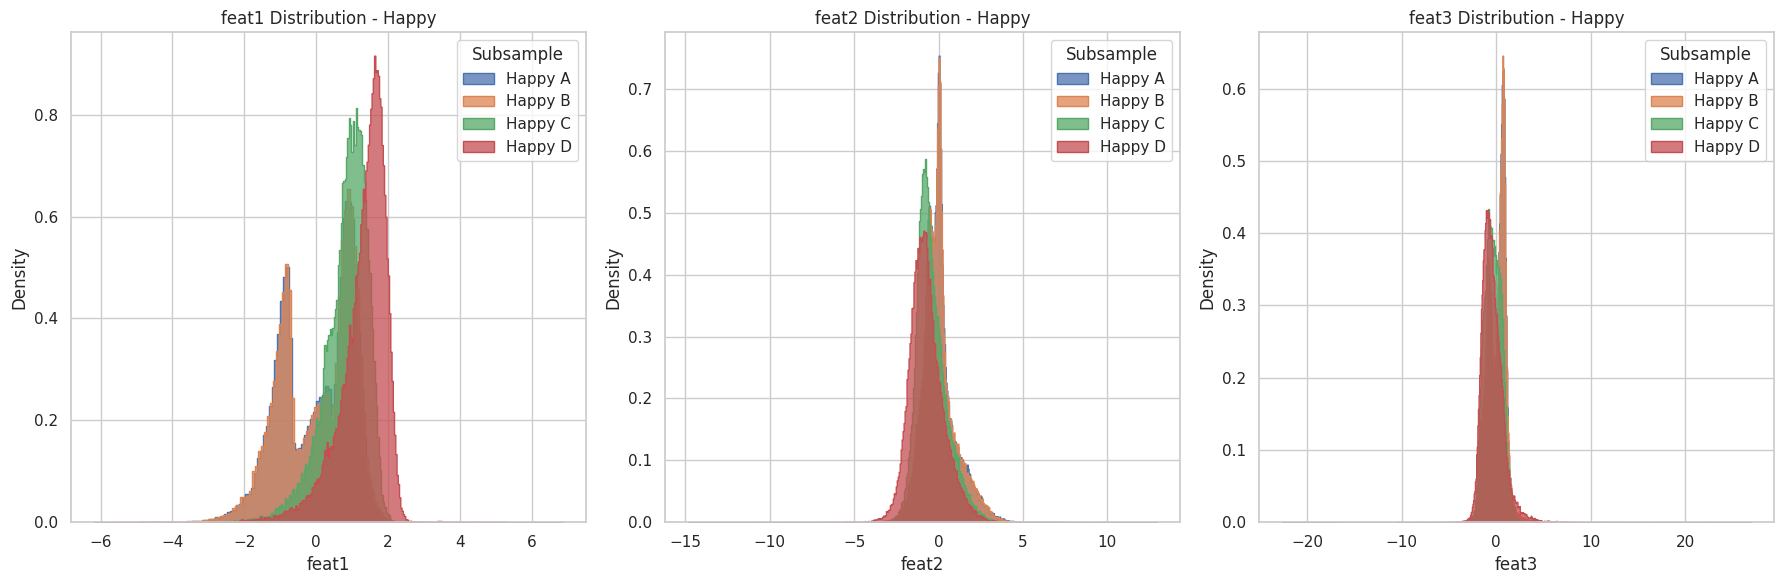

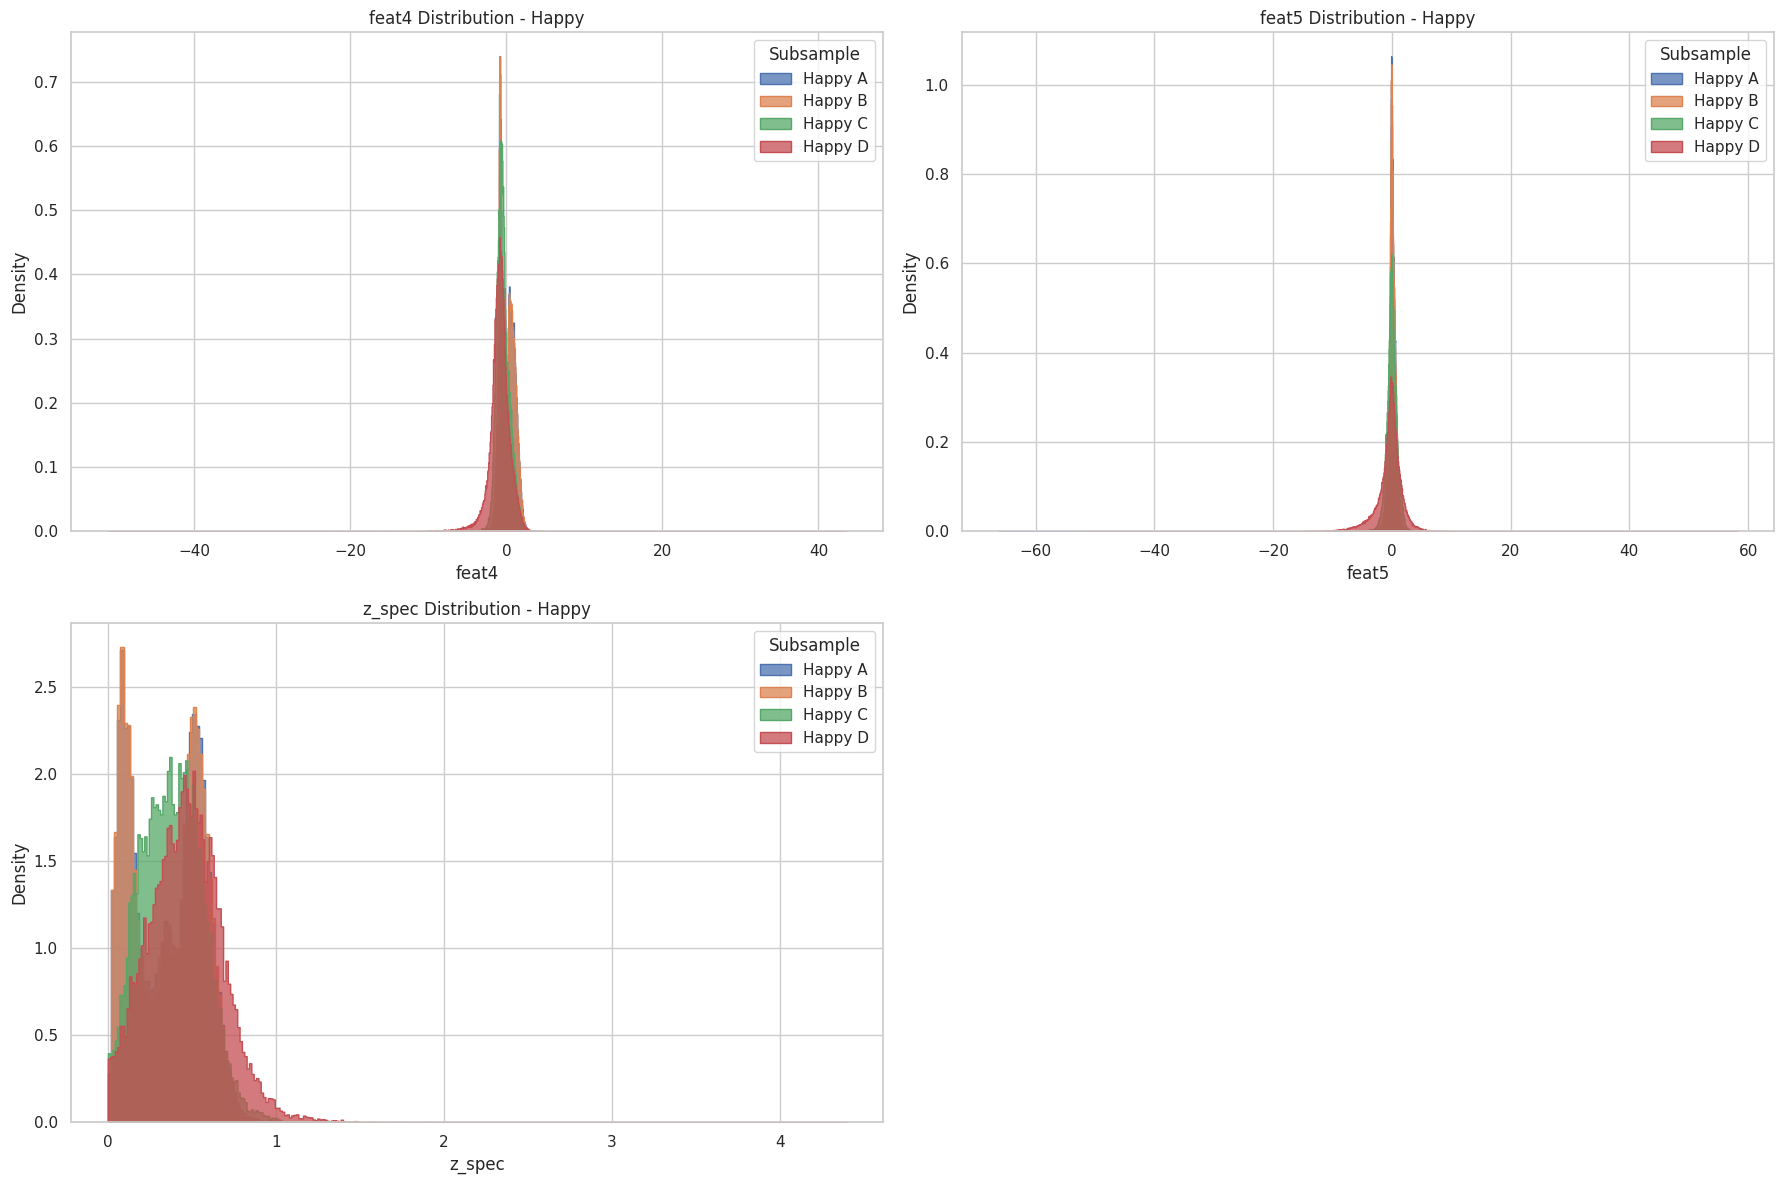

In [ ]:
def plot_histograms(dataset, dataset_name):
    """
    Plot histograms for selected features in the dataset, grouped by subsamples.

    Args:
    dataset (DataFrame): The dataset to plot, containing the specified features and a 'Subsample' column.
    dataset_name (str): Name of the dataset, used for labeling the plots.

    The function plots histograms for two groups of features:
    - Group 1: ['feat1', 'feat2', 'feat3'] displayed in a single row of three subplots.
    - Group 2: ['feat4', 'feat5', 'z_spec'] displayed in a 2x2 grid.

    Histograms are plotted for each subsample within the dataset, allowing for comparison across subsamples.
    Density plots with 'step' elements and non-common normalization are used to distinguish distributions.
    Legends are included for clarity, and `plt.tight_layout()` ensures proper spacing.
    """
    features_group1 = ['feat1', 'feat2', 'feat3']
    features_group2 = ['feat4', 'feat5', 'z_spec']
    subsamples = dataset['Subsample'].unique()

    # Plot for the first group of features
    plt.figure(figsize=(18, 6))
    for i, feature in enumerate(features_group1, 1):
        plt.subplot(1, 3, i)
        for subsample in subsamples:
            subset = dataset[dataset['Subsample'] == subsample]
            sns.histplot(data=subset, x=feature, label=subsample, element='step', stat='density', common_norm=False)
        plt.title(f'{feature} Distribution - {dataset_name}')
        plt.legend(title='Subsample')
    plt.tight_layout()
    plt.show()

    # Plot for the second group of features
    plt.figure(figsize=(18, 12))
    for i, feature in enumerate(features_group2, 1):
        plt.subplot(2, 2, i)
        for subsample in subsamples:
            subset = dataset[dataset['Subsample'] == subsample]
            sns.histplot(data=subset, x=feature, label=subsample, element='step', stat='density', common_norm=False)
        plt.title(f'{feature} Distribution - {dataset_name}')
        plt.legend(title='Subsample')
    plt.tight_layout()
    plt.show()

plot_histograms(happy, 'Happy')

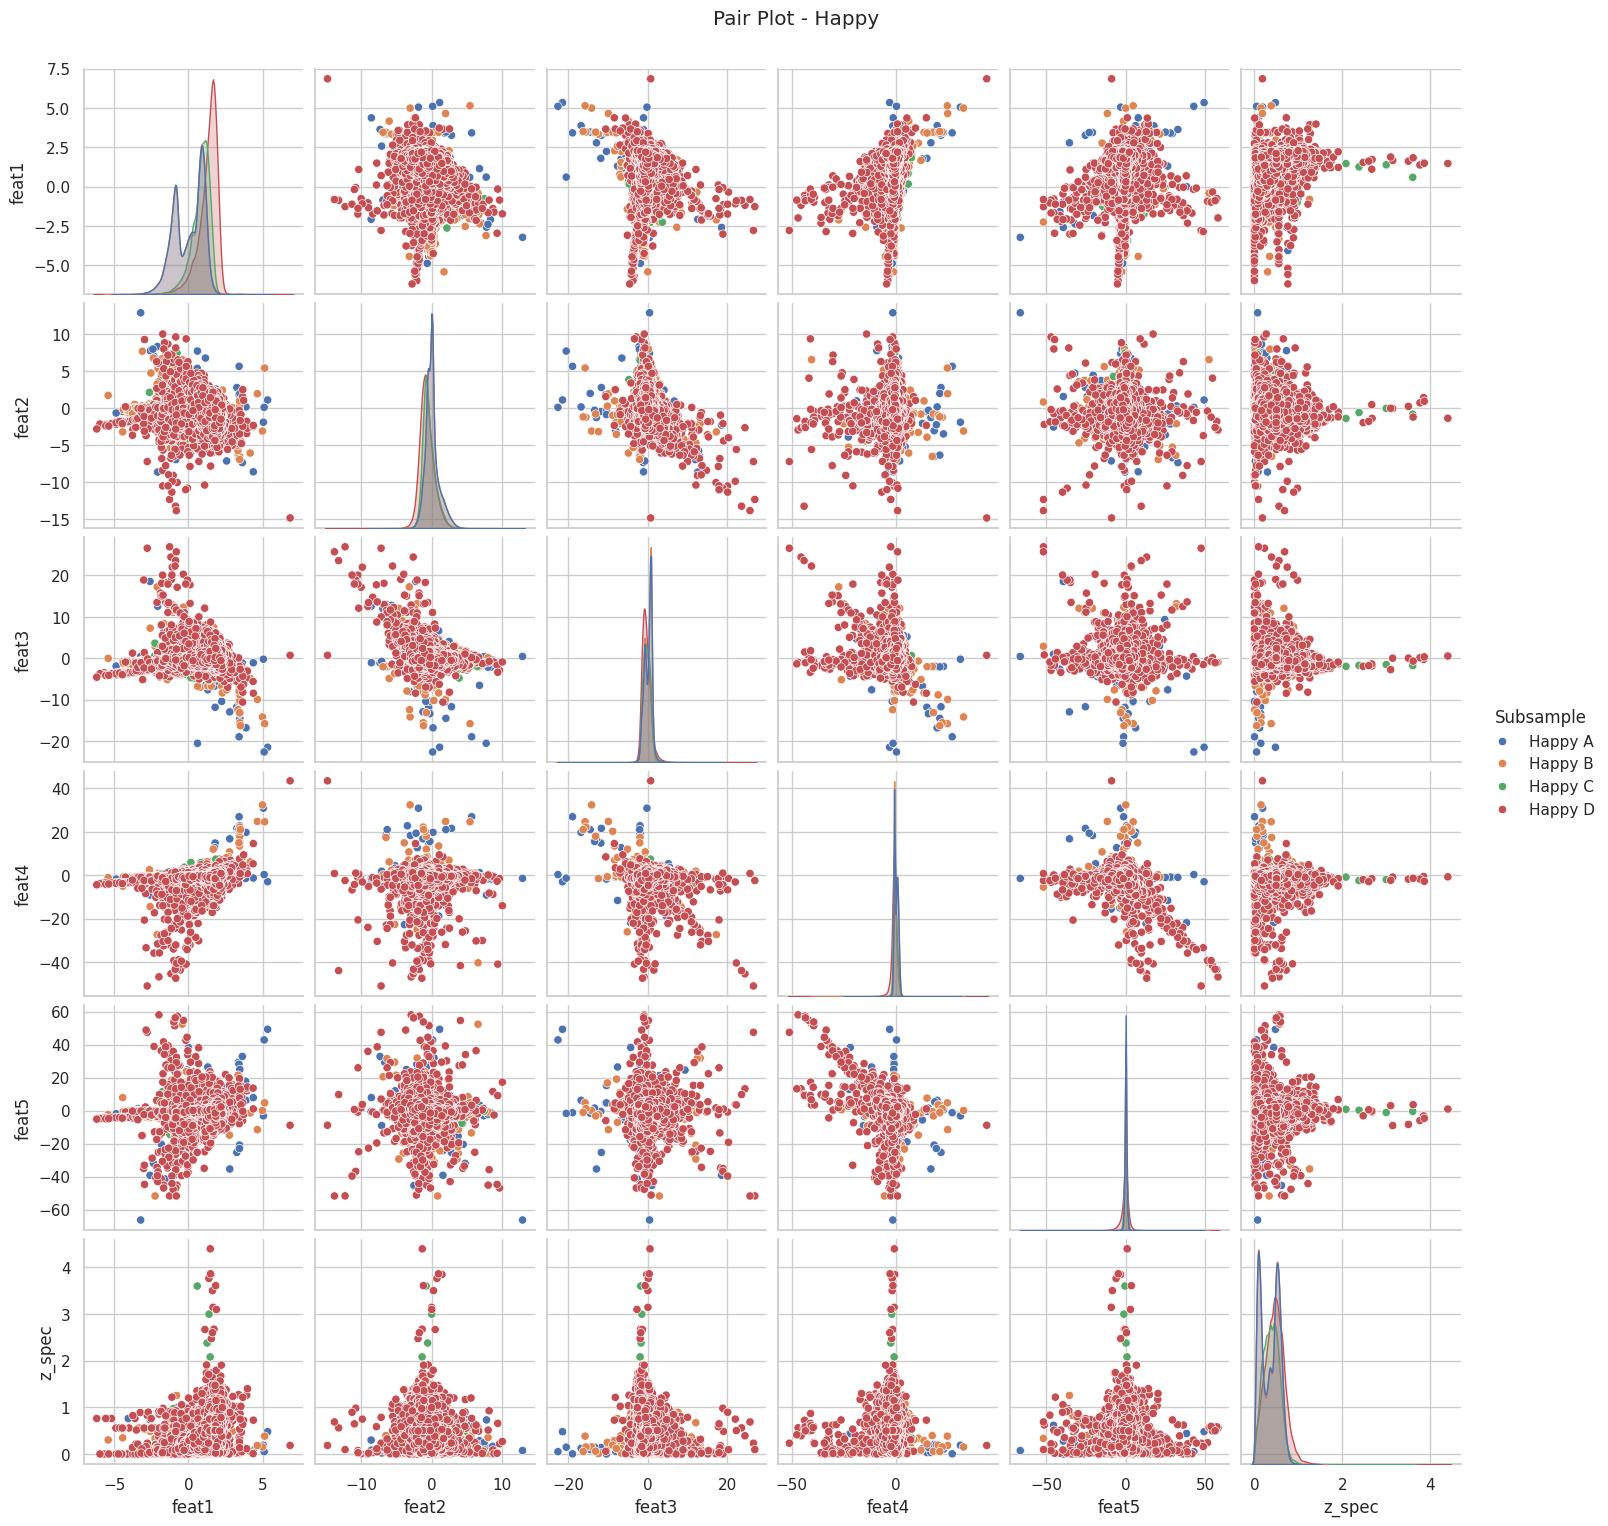

In [ ]:
# Define the function to create a pair plot
def plot_pairplot(dataset, dataset_name):
    """
    Create a pair plot of selected features in the dataset, colored by subsample.

    Args:
    dataset (DataFrame): The dataset to plot. Must include the specified features and a 'Subsample' column.
    dataset_name (str): Name of the dataset to be used in the plot title.

    Raises:
    ValueError: If the dataset does not contain all required columns.

    The function creates a pair plot using seaborn's `pairplot` function, displaying scatterplots and
    histograms for all pairs of the specified features. The plot uses color coding based on the
    'Subsample' column to differentiate between different subsample groups.

    Features Included:
    - 'feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'z_spec'

    Plot Details:
    - The pair plot includes scatterplots for each pair of features and histograms for individual features.
    - The `hue='Subsample'` parameter colors the data points based on subsample groups.
    - The plot title is adjusted to display above the figure.
    """
    # Define the features to include in the pair plot
    features = ['feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'z_spec']

    # Ensure that the necessary columns are in the dataset
    if not all(col in dataset.columns for col in features + ['Subsample']):
        raise ValueError(f"Dataset must contain the following columns: {', '.join(features + ['Subsample'])}")

    # Create the pair plot
    pairplot = sns.pairplot(dataset, hue='Subsample', vars=features)
    pairplot.fig.suptitle(f'Pair Plot - {dataset_name}', y=1.02)  # Adjust title position

    # Display the plot
    plt.show()

# Call the function for the 'happy' dataset
plot_pairplot(happy, 'Happy')


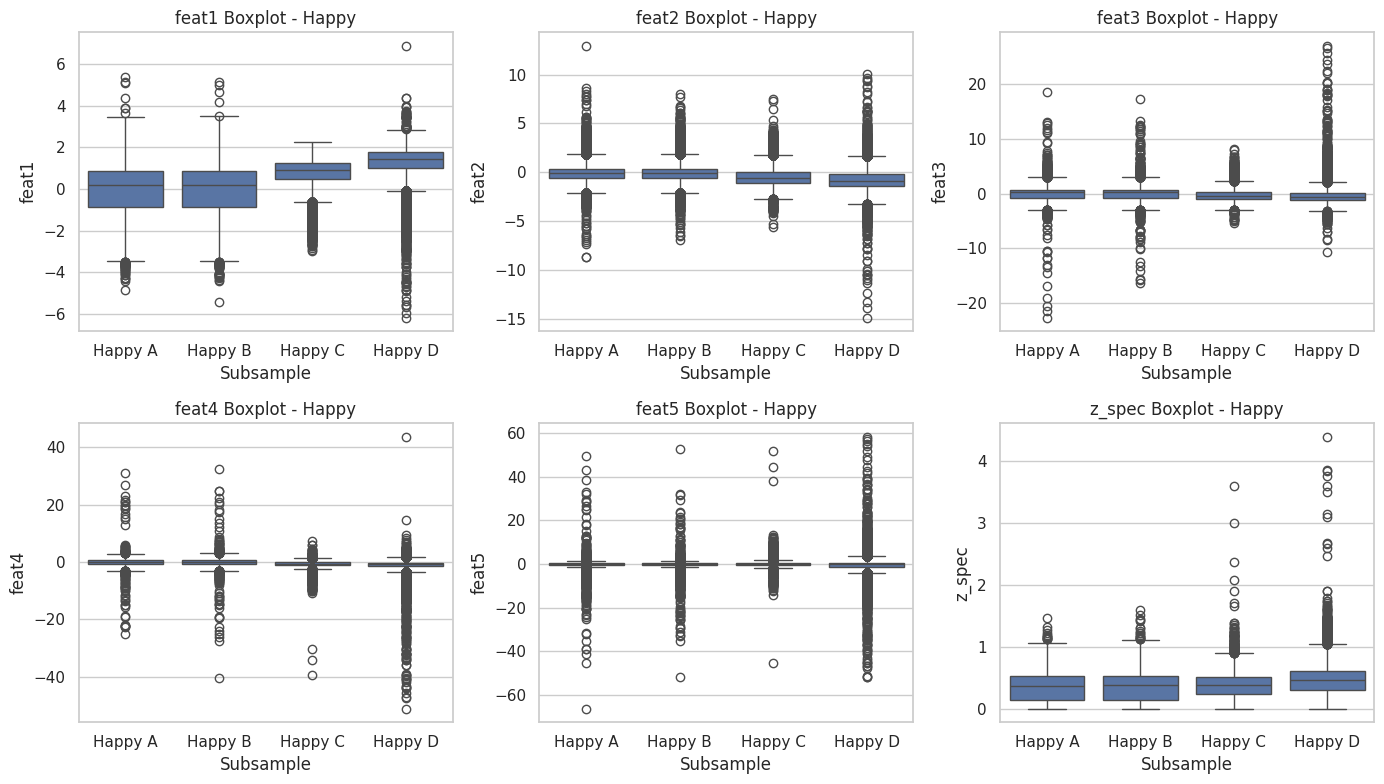

In [ ]:
# Define the function to create box plots
def plot_boxplots(dataset, dataset_name):
    """
    Plot box plots for selected features in the dataset, grouped by subsample.

    Args:
    dataset (DataFrame): The dataset to plot. Must include the specified features and a 'Subsample' column.
    dataset_name (str): Name of the dataset for use in the plot titles.

    The function generates box plots for each feature listed, showing the distribution of values
    across different subsample groups. Each box plot is created for a specific feature with
    'Subsample' as the categorical axis.

    Features Included:
    - 'feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'z_spec'

    Plot Details:
    - The number of subplots adjusts based on the number of features, arranged in a grid layout.
    - The plot uses seaborn's `boxplot` function to visualize the distribution of each feature's values.
    - Each subplot is labeled with the feature name and dataset name.
    - `plt.tight_layout()` ensures that subplots do not overlap.
    """
    # Define the features to plot
    features = ['feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'z_spec']

    # Determine the number of rows and columns needed for the subplot grid
    num_features = len(features)
    num_cols = 3  # Number of columns for subplots
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate the number of rows

    plt.figure(figsize=(14, 4 * num_rows))  # Adjust height based on the number of rows

    for i, feature in enumerate(features, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.boxplot(data=dataset, x='Subsample', y=feature)
        plt.title(f'{feature} Boxplot - {dataset_name}')

    plt.tight_layout()
    plt.show()

# Call the function for the 'happy' dataset
plot_boxplots(happy, 'Happy')


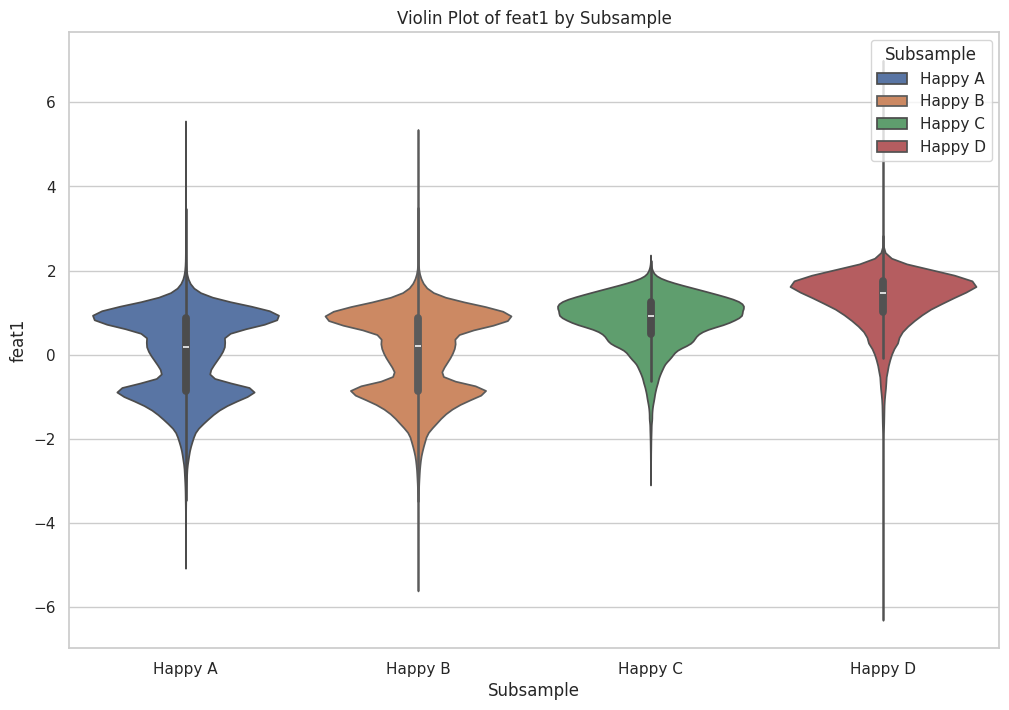

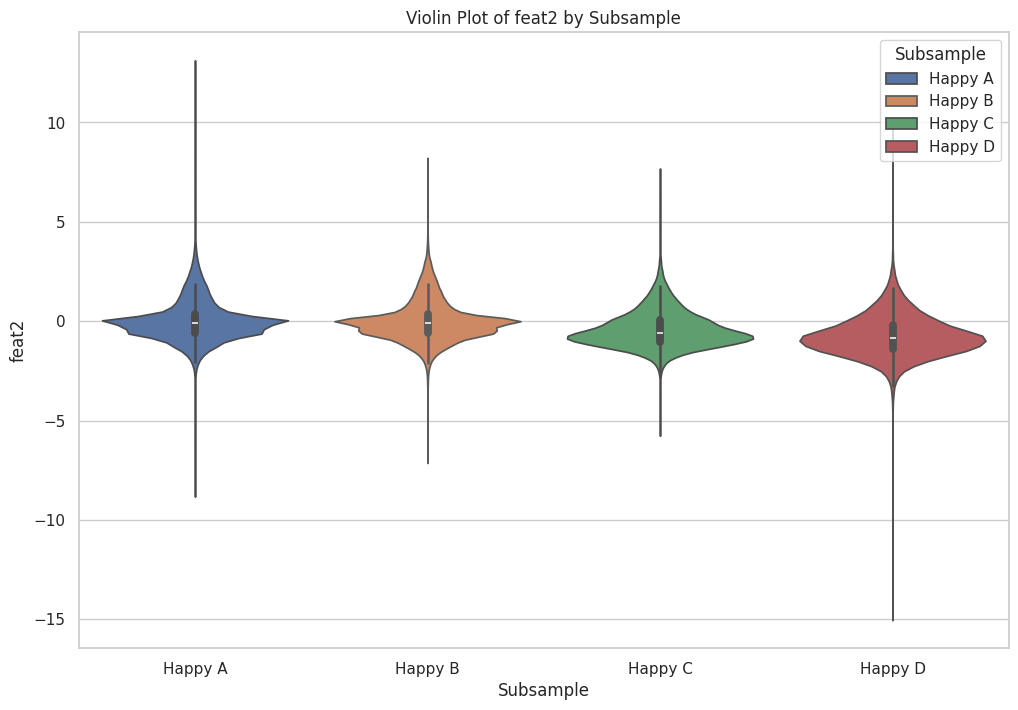

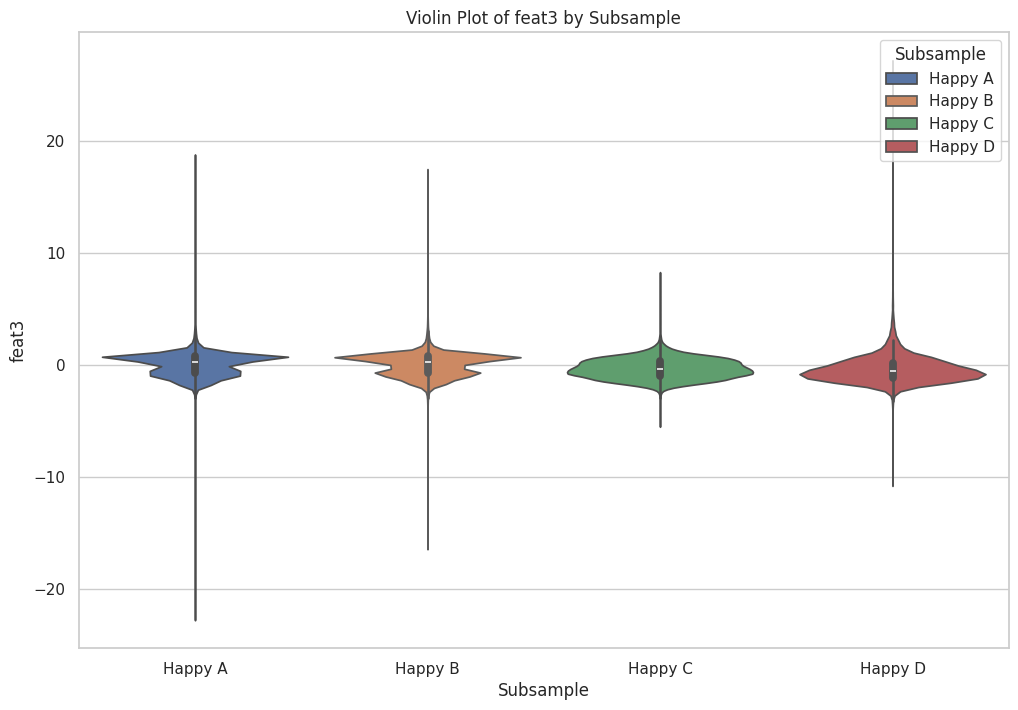

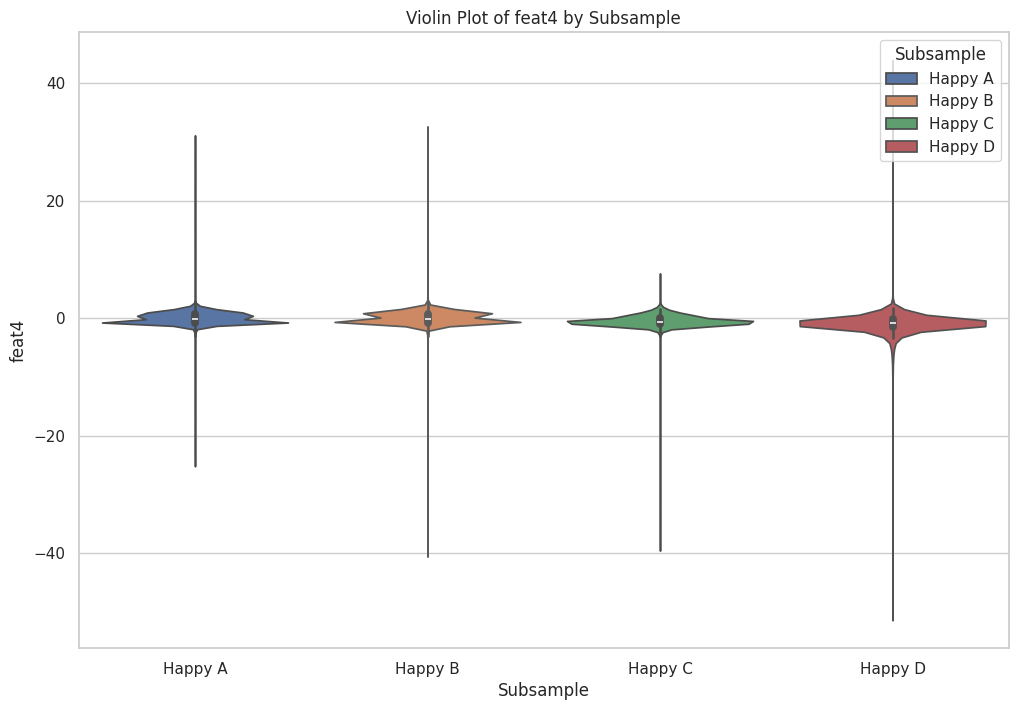

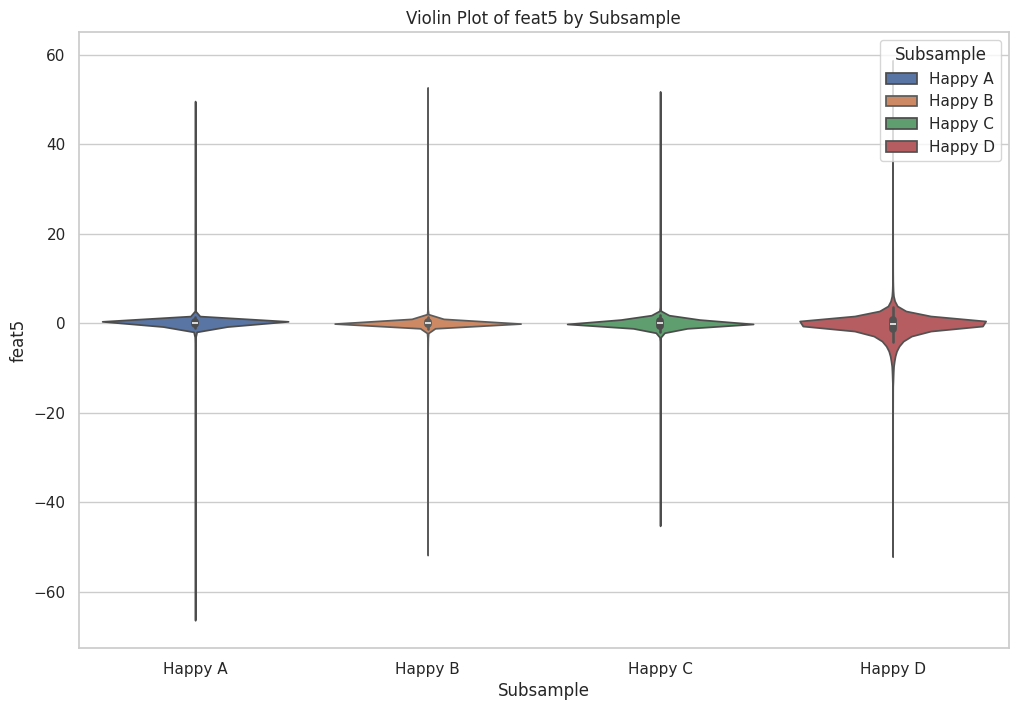

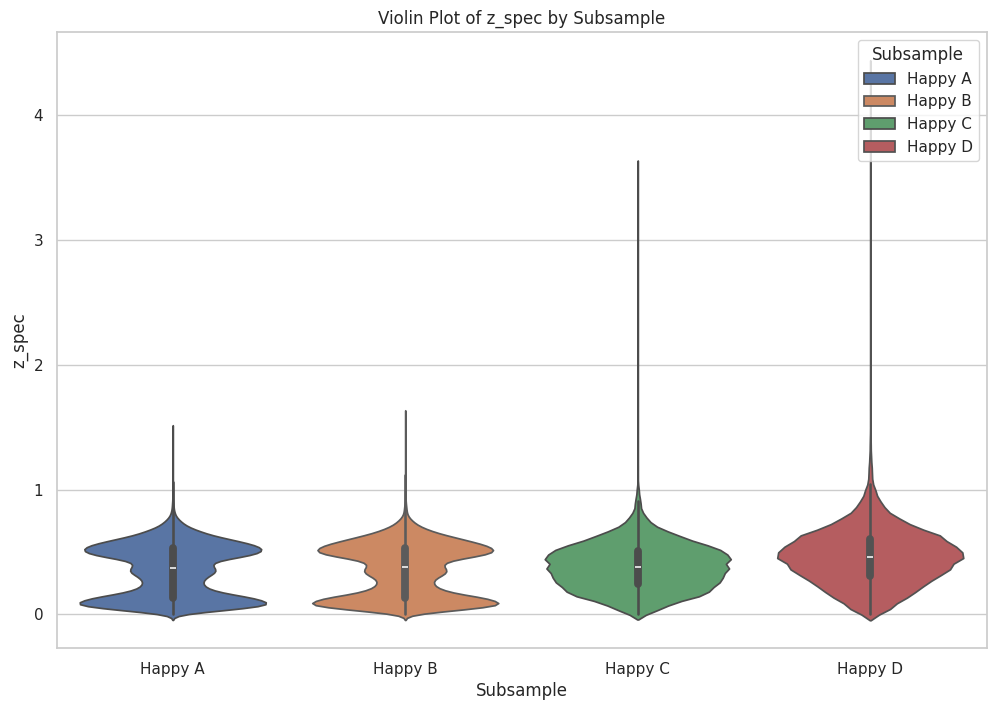

In [ ]:
# Define the function to create a violin plot
def plot_violin(dataset, dataset_name, feature):
    """
    Plot a violin plot for a specified feature in the dataset, grouped by subsample.

    Args:
    dataset (DataFrame): The dataset to plot, including the specified feature and a 'Subsample' column.
    dataset_name (str): Name of the dataset, used in the plot title.
    feature (str): The feature for which to plot the violin plot.

    The function creates a violin plot showing the distribution of the specified feature across
    different subsample groups. The plot visualizes the density of the feature's values with
    respect to each subsample.

    Plot Details:
    - The plot is sized for clarity and includes a title indicating the feature and dataset.
    """
    plt.figure(figsize=(12, 8))  # Adjust size for better readability

    # Create the violin plot
    sns.violinplot(data=dataset, x='Subsample', y=feature)
    plt.title(f'Violin Plot of {feature} - {dataset_name}')
    plt.show()

# Function to plot violin plots for all features and subsamples
def plot_violin_plots_for_subsamples(dataset):
    """
    Plot violin plots for all selected features in the dataset, grouped by subsample.

    Args:
    dataset (DataFrame): The dataset to plot, including the specified features and a 'Subsample' column.

    The function generates violin plots for each feature, visualizing how the feature's
    distribution varies across different subsample groups. Each plot includes multiple
    violins for the subsample groups to show the density and distribution of values.

    Features Included:
    - 'feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'z_spec'

    Plot Details:
    - Each feature is plotted in its own figure.
    - Each violin plot displays the distribution for the feature across subsample groups.
    - A legend distinguishes between different subsamples in each plot.
    """
    subsamples = dataset['Subsample'].unique()
    features = ['feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'z_spec']

    for feature in features:
        plt.figure(figsize=(12, 8))
        for subsample in subsamples:
            subset = dataset[dataset['Subsample'] == subsample]
            sns.violinplot(data=subset, x='Subsample', y=feature, label=subsample)
        plt.title(f'Violin Plot of {feature} by Subsample')
        plt.legend(title='Subsample')
        plt.show()

# Plot violin plots for each feature and subsample in the Happy dataset
plot_violin_plots_for_subsamples(happy)


In [ ]:
# Load the cleaned Teddy dataset
teddy = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/cleaned_teddy_dataset.csv')

# Adding a 'Subsample' column to each dataset
for df, subsample in zip([teddy_A, teddy_B, teddy_C, teddy_D], ['Teddy A', 'Teddy B', 'Teddy C', 'Teddy D']):
    df['Subsample'] = subsample
# Combine the Teddy datasets into one DataFrame
teddy = pd.concat([teddy_A, teddy_B, teddy_C, teddy_D], ignore_index=True)

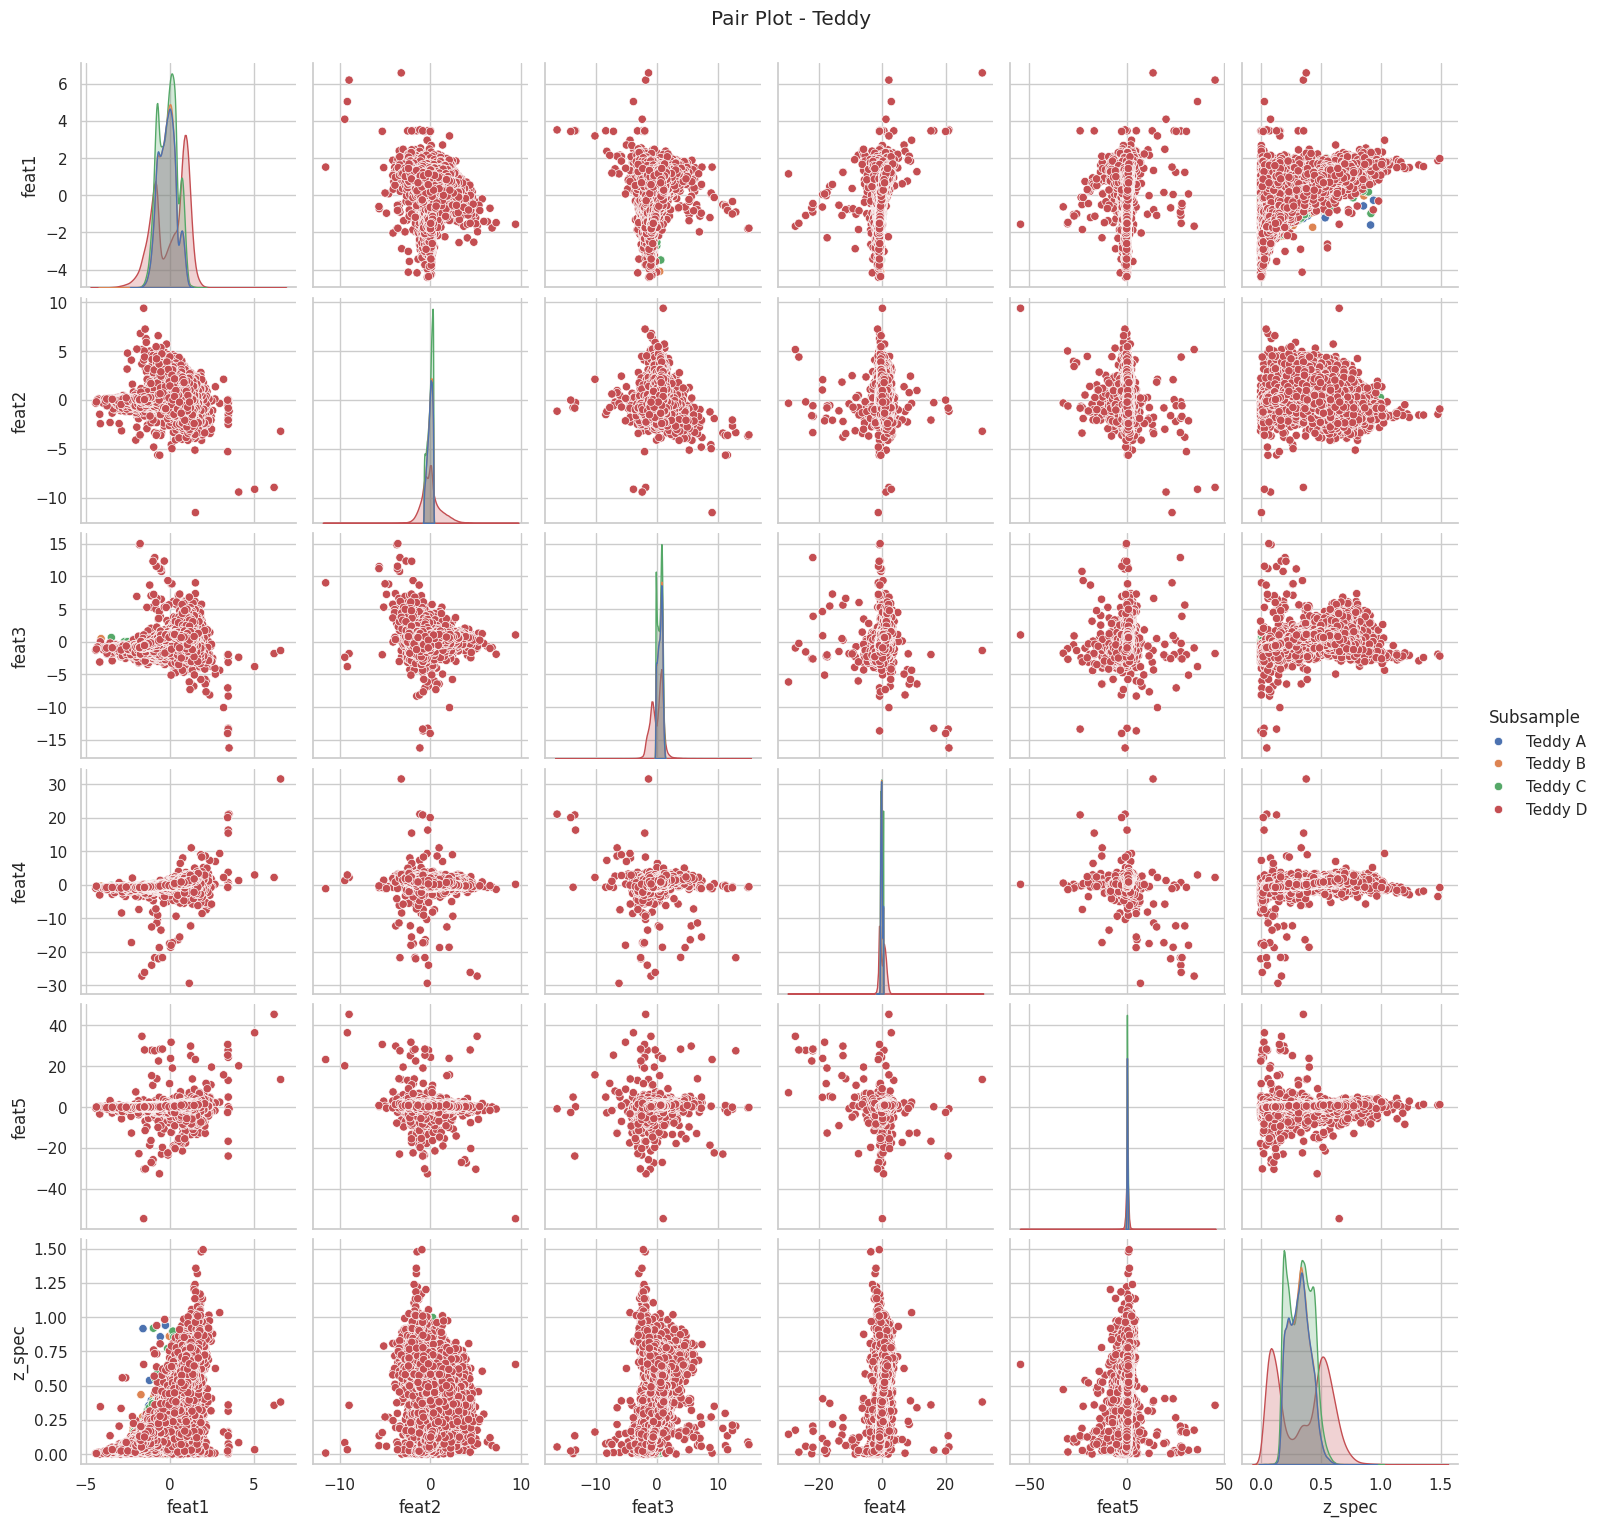

In [ ]:
# Pair plots for Teddy dataset
plot_pairplot(teddy, 'Teddy')


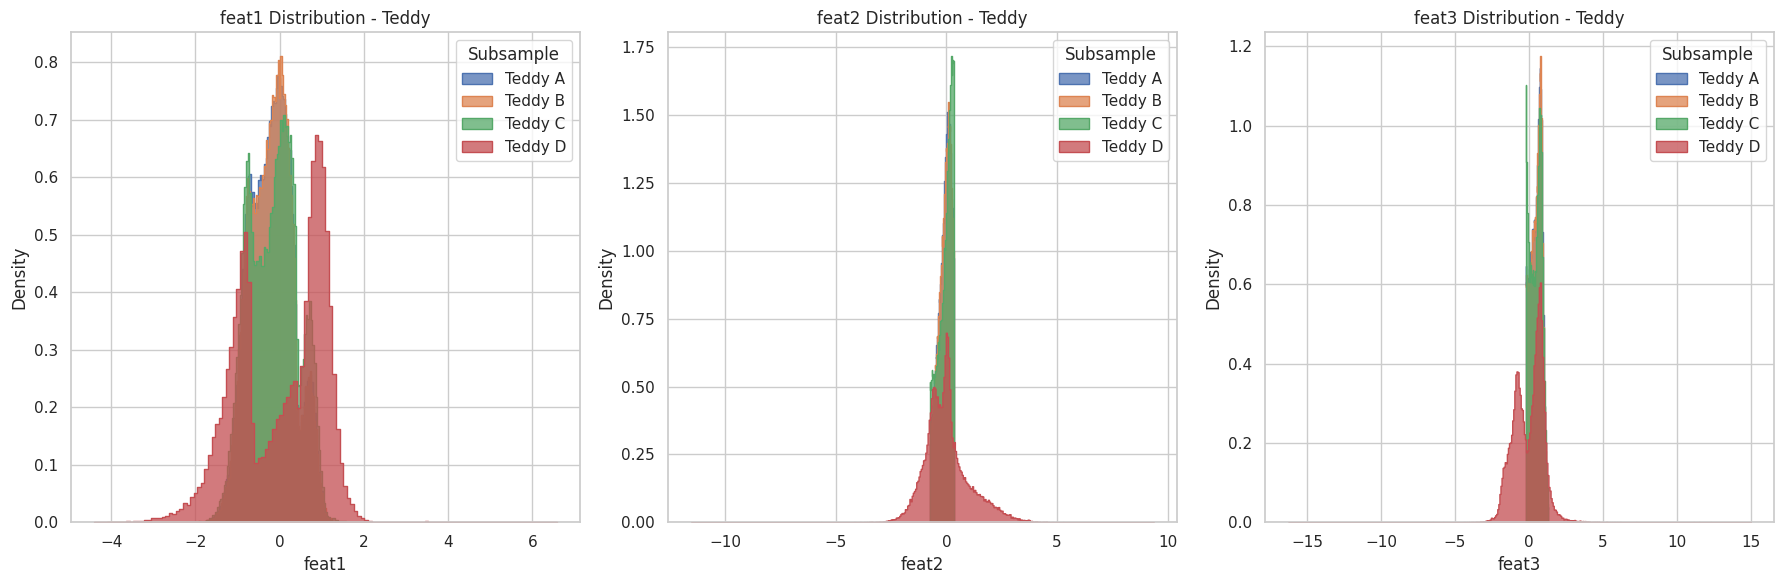

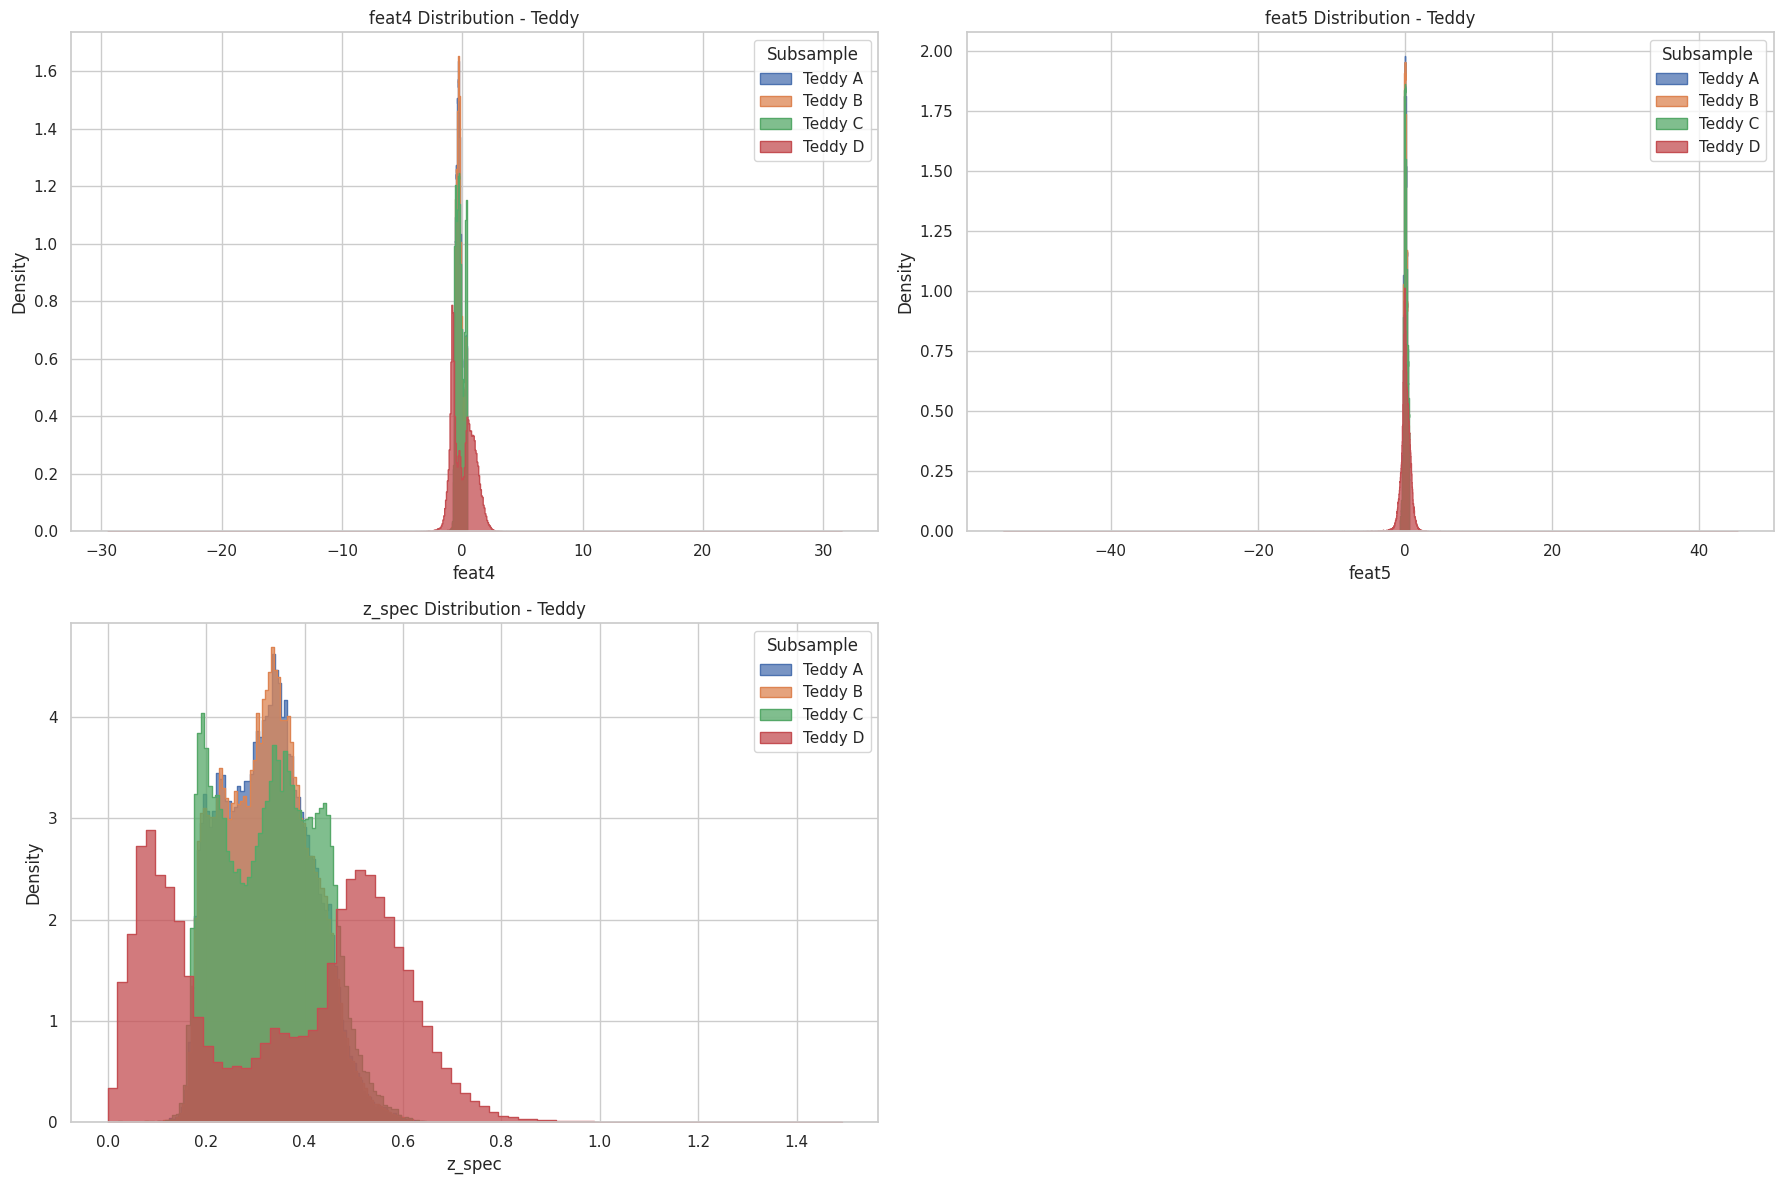

In [ ]:
# Histograms for Teddy dataset
plot_histograms(teddy, 'Teddy')


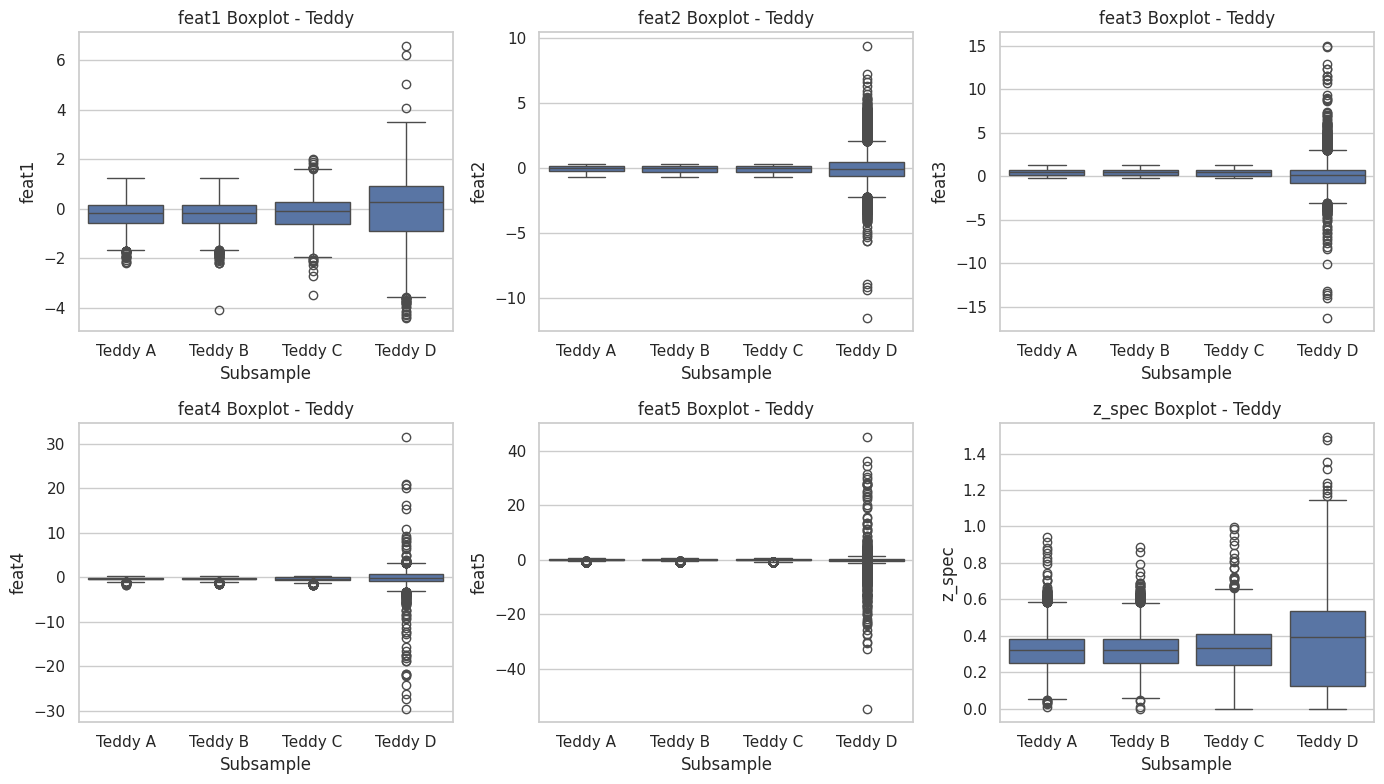

In [ ]:
# Box plots for Teddy dataset
plot_boxplots(teddy, 'Teddy')


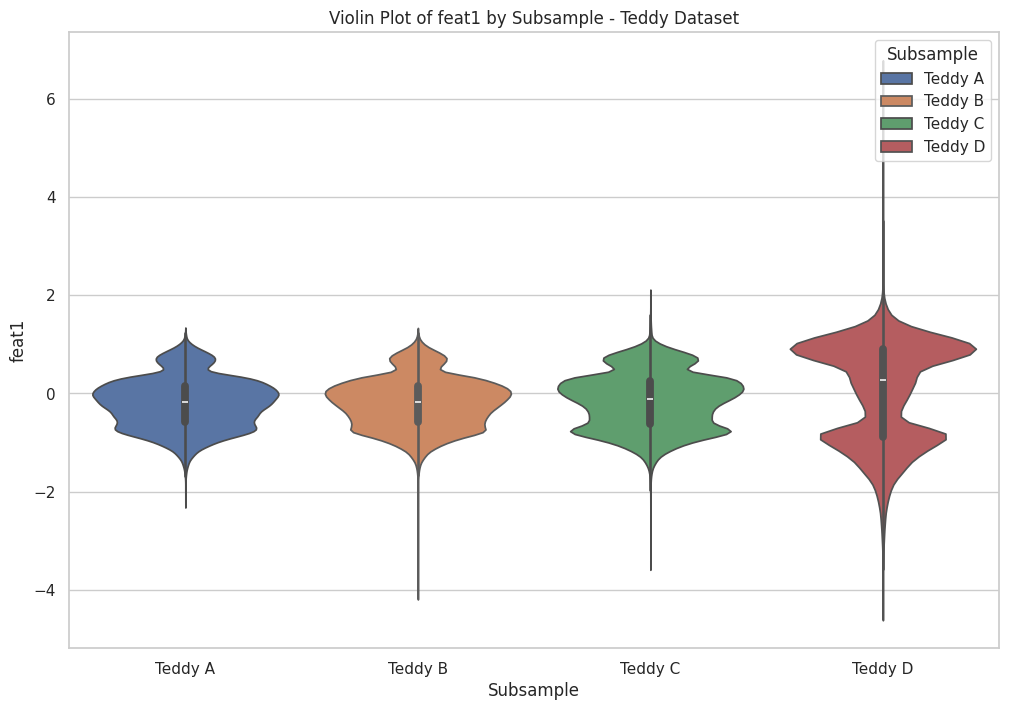

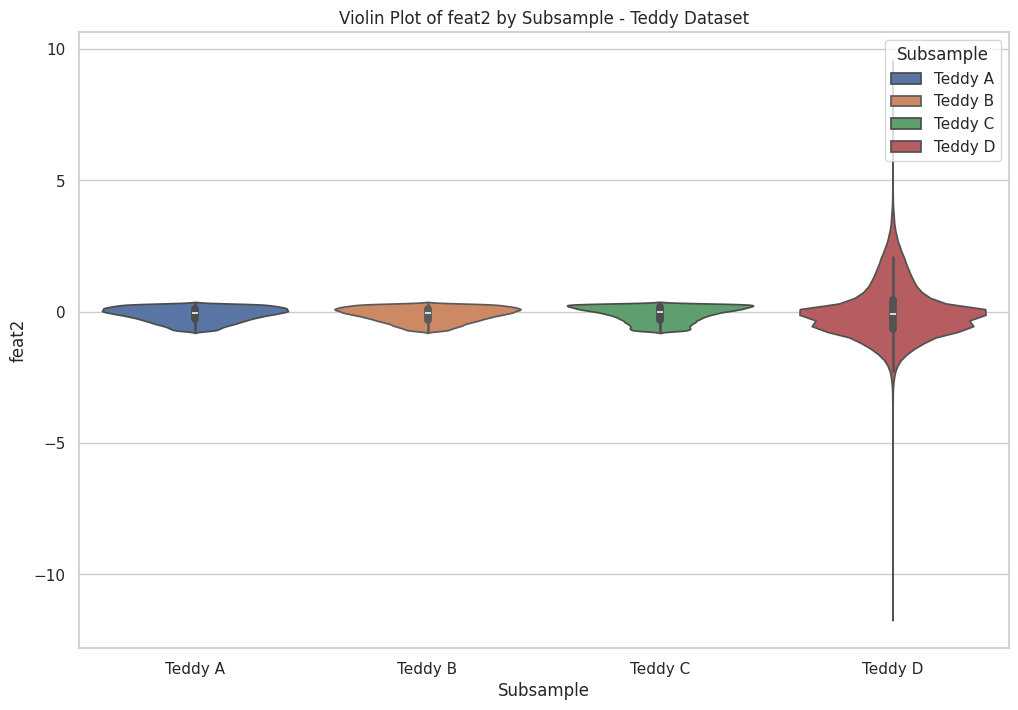

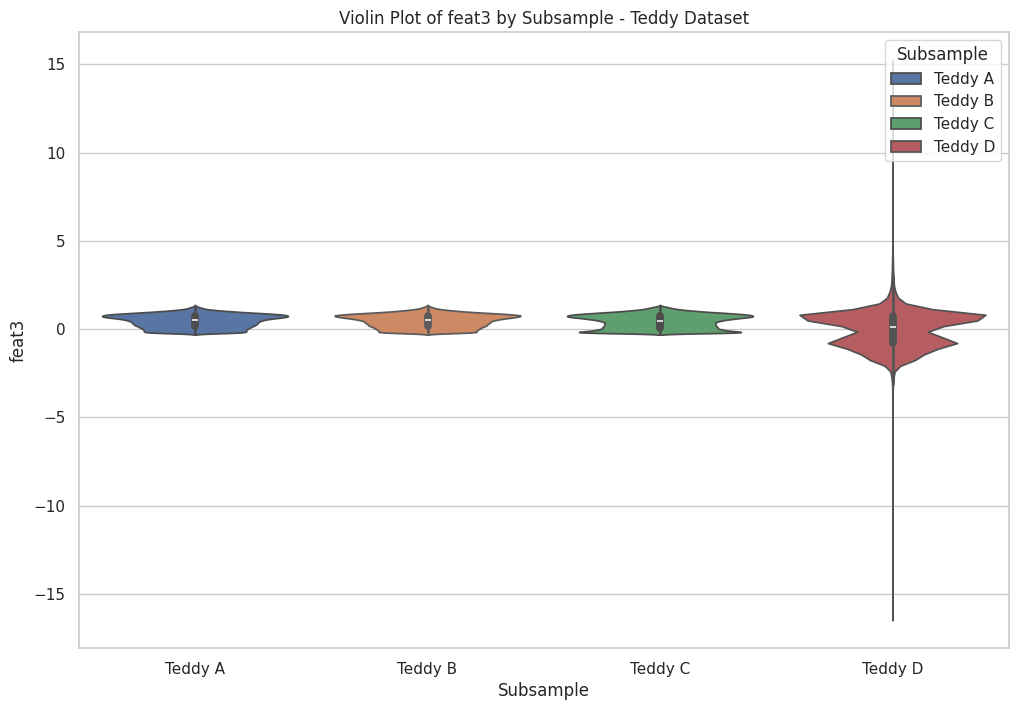

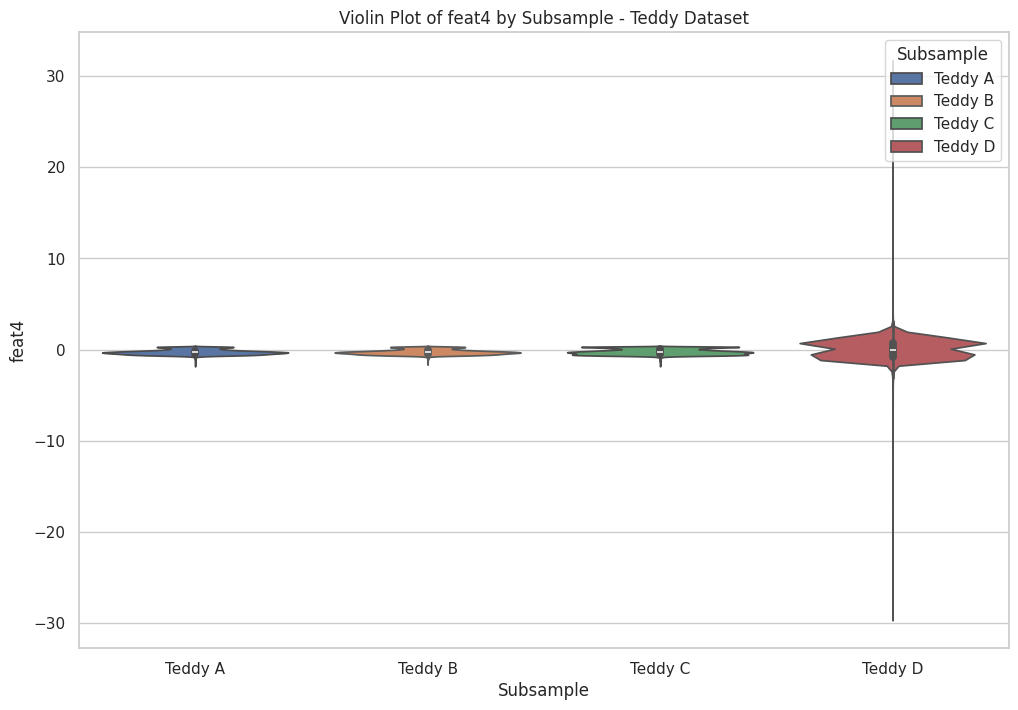

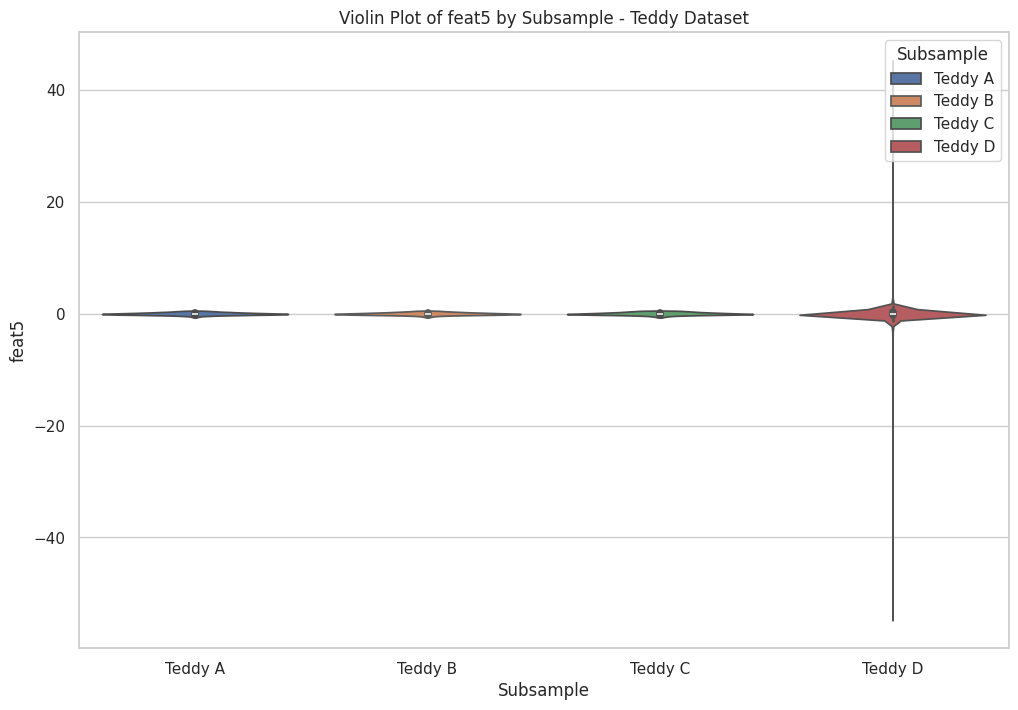

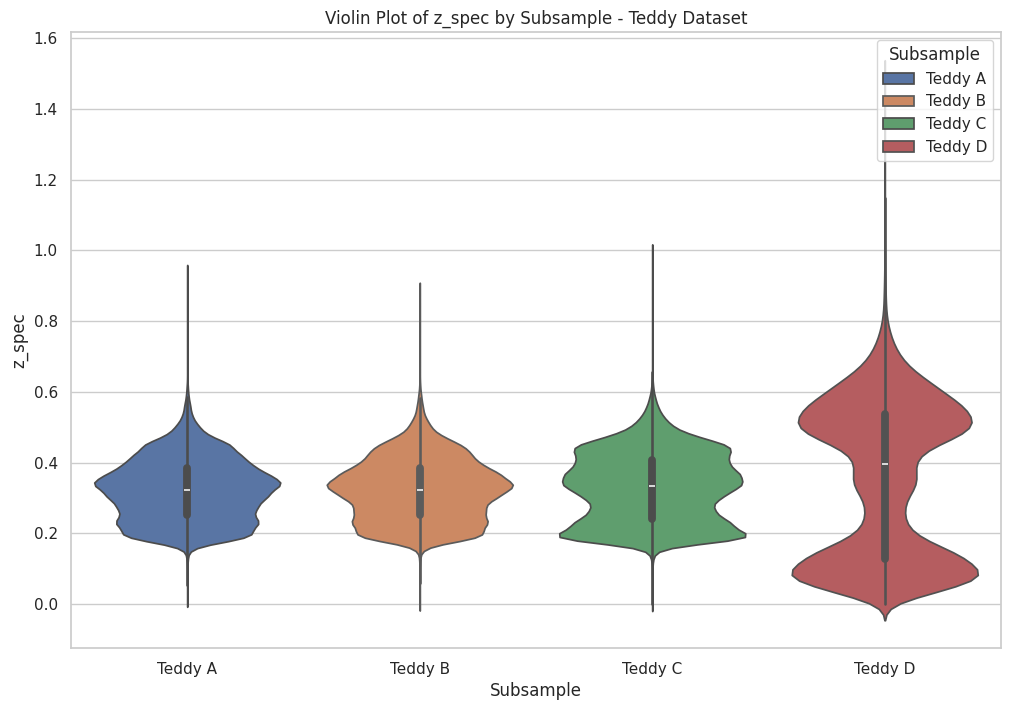

In [ ]:
# Function to plot violin plots for each feature and subsample in the Teddy dataset
def plot_violin_plots_teddy(dataset):
    """
    Plot violin plots for each feature in the Teddy dataset, grouped by subsample.

    Args:
    dataset (DataFrame): The dataset to plot, including the specified features and a 'Subsample' column.

    The function generates violin plots for each feature, showing the distribution of values
    across different subsample groups. Each plot visualizes how the feature's density varies
    with respect to each subsample.

    Features Included:
    - 'feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'z_spec'

    Plot Details:
    - Each feature is plotted in a separate figure.
    - Violin plots display the distribution for each feature across different subsample groups.
    - A legend is included to distinguish between subsample groups.
    - The plot title specifies the feature and indicates it is for the Teddy dataset.
    """
    subsamples = dataset['Subsample'].unique()
    features = ['feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'z_spec']

    for feature in features:
        plt.figure(figsize=(12, 8))
        for subsample in subsamples:
            subset = dataset[dataset['Subsample'] == subsample]
            sns.violinplot(data=subset, x='Subsample', y=feature, label=subsample)
        plt.title(f'Violin Plot of {feature} by Subsample - Teddy Dataset')
        plt.legend(title='Subsample')
        plt.show()

# Plot violin plots for the Teddy dataset
plot_violin_plots_teddy(teddy)


#Feature Selection and Normalization

Normalize the features to ensure all are on the same scale, which is important for algorithms like Gradient Boosting and Neural Networks.The process includes:

**1. Loading Cleaned Datasets:** Reads the pre-processed datasets (happy and teddy) from CSV files.

**2. Feature Selection:** Specifies which features (feat1 to feat5) will be used for training and testing, and identifies the target variable (z_spec).

**3. Normalization:** Standardizes the selected features to have a mean of 0 and a standard deviation of 1 using StandardScaler. This step ensures that all features contribute equally to the analysis.

**4. Data Conversion:** Converts the scaled feature arrays back into DataFrames for better readability and ease of use.

**5. Saving Scaled Datasets:** Saves the scaled feature DataFrames to new CSV files for future use in modeling or analysis.

In [5]:
# Load the cleaned datasets
happy = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/cleaned_happy_dataset.csv')
teddy = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/cleaned_teddy_dataset.csv')

# Feature selection: Choose relevant features for training and testing
features = ['feat1', 'feat2', 'feat3', 'feat4', 'feat5']  # Features to use for modeling
target = 'z_spec'  # Target variable for prediction

# Extract feature and target variables for both datasets
X_happy = happy[features]
y_happy = happy[target]
X_teddy = teddy[features]
y_teddy = teddy[target]

# Normalization: Standardize the features to have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()  # Initialize the scaler

# Fit the scaler on the happy dataset and transform both datasets
X_happy_scaled = scaler.fit_transform(X_happy)
X_teddy_scaled = scaler.transform(X_teddy)  # Use the same scaler for consistency

# Convert the scaled arrays back to DataFrames for better readability
X_happy_scaled = pd.DataFrame(X_happy_scaled, columns=features)
X_teddy_scaled = pd.DataFrame(X_teddy_scaled, columns=features)

# Save the scaled datasets to CSV files for further analysis
X_happy_scaled.to_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/scaled_happy_features.csv', index=False)
X_teddy_scaled.to_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/scaled_teddy_features.csv', index=False)

print("Feature selection and normalization are complete. Scaled datasets have been saved.")


Feature selection and normalization are complete. Scaled datasets have been saved.




#Model Training, Evaluation, and Visualization



 Evaluate the performance of each model using metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²).
This section covers the following key steps in the machine learning workflow:

**1. Set Up Visualization Aesthetics:**

Configures Seaborn for consistent and visually appealing plots.

**2. Load and Prepare Data:**

Loads the preprocessed and scaled feature datasets for both "Happy" and "Teddy" datasets.
Splits the data into training and testing sets for model evaluation.

**3. Initialize and Configure Models:**

Defines a range of regression models including Random Forest, Gradient Boosting, Neural Network, Decision Tree, and XGBoost.
Sets up hyperparameter grids for tuning Random Forest, Gradient Boosting, and XGBoost.

**4. Train and Evaluate Models:**

Trains the models using the training set and evaluates them on the test set.
Uses grid search for hyperparameter tuning where applicable and saves the best-performing models.

**5. Visualize Model Performance:**

Generates scatter plots to compare true values against predictions, providing insights into model accuracy and performance.
This section ensures comprehensive model training, evaluation, and visualization, aiding in effective analysis and interpretation of model results.














In [7]:
# Set Seaborn style and color palette for plots
sns.set(style='whitegrid')
palette = sns.color_palette()

# Load the scaled datasets
X_happy = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/scaled_happy_features.csv')
y_happy = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/cleaned_happy_dataset.csv')['z_spec']

X_teddy = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/scaled_teddy_features.csv')
y_teddy = pd.read_csv('/content/drive/MyDrive/photoz_catalogues-master/photoz_catalogues-master/cleaned_teddy_dataset.csv')['z_spec']

# Split the data into training and testing sets
X_train_happy, X_test_happy, y_train_happy, y_test_happy = train_test_split(X_happy, y_happy, test_size=0.2, random_state=42)
X_train_teddy, X_test_teddy, y_train_teddy, y_test_teddy = train_test_split(X_teddy, y_teddy, test_size=0.2, random_state=42)

# Path to save the models
save_path = '/content/drive/MyDrive/photoz_catalogues-master/'

# Initialize models with their respective configurations
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Hyperparameter tuning grids for selected models
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Function to train and evaluate a model
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Train and evaluate the model on the given training and test data.

    Args:
    model: The model to train and evaluate.
    X_train: Training feature set.
    y_train: Training target variable.
    X_test: Test feature set.
    y_test: Test target variable.
    model_name: Name of the model for saving purposes.

    Returns:
    rmse: Root Mean Squared Error of the model's predictions.
    mae: Mean Absolute Error of the model's predictions.
    r2: R-squared score of the model's predictions.
    model: The trained model.
    """
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Save the trained model using pickle
    model_file_path = os.path.join(save_path, f'{model_name}.pkl')
    with open(model_file_path, 'wb') as file:
        pickle.dump(model, file)

    return rmse, mae, r2, model

# Function to plot results
def plot_results(y_true, y_pred, title):
    """
    Plot the true values vs. predictions to visualize model performance.

    Args:
    y_true: True target values.
    y_pred: Predicted values from the model.
    title: Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.3, color=palette[-1])
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('True Values', fontsize=14)
    plt.ylabel('Predictions', fontsize=14)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(True)
    plt.show()

# Updated function to train and evaluate models with multiple test sets
def train_evaluate_model_with_datasets(models, X_train, y_train, X_tests, dataset_name):
    """
    Train and evaluate models with hyperparameter tuning and multiple test datasets.

    Args:
    models: Dictionary of models to train and evaluate.
    X_train: Training feature set.
    y_train: Training target variable.
    X_tests: Dictionary of test datasets (feature set and target variable).
    dataset_name: Name of the dataset for identification in results.
    """
    for name, model in models.items():
        if name == "Random Forest":
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid_rf, cv=2, n_jobs=1, scoring='neg_mean_squared_error')
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        elif name == "Gradient Boosting":
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid_gb, cv=2, n_jobs=1, scoring='neg_mean_squared_error')
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        elif name == "XGBoost":
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid_xgb, cv=2, n_jobs=1, scoring='neg_mean_squared_error')
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        else:
            best_model = model
            best_model.fit(X_train, y_train)

        # Evaluate the best model on each test dataset
        for test_name, (X_test, y_test) in X_tests.items():
            rmse, mae, r2, _ = train_evaluate_model(best_model, X_train, y_train, X_test, y_test, f'best_model_{dataset_name}_{name}_{test_name}')
            print(f"{dataset_name} {test_name} - {name} - RMSE: {rmse}, MAE: {mae}, R²: {r2}")
            plot_results(y_test, best_model.predict(X_test), f"{dataset_name} {test_name} - True vs Predicted Values ({name})")


Happy Dataset:
Happy B - Random Forest - RMSE: 0.06817799050924, MAE: 0.04389236029898522, R²: 0.8959190714477511


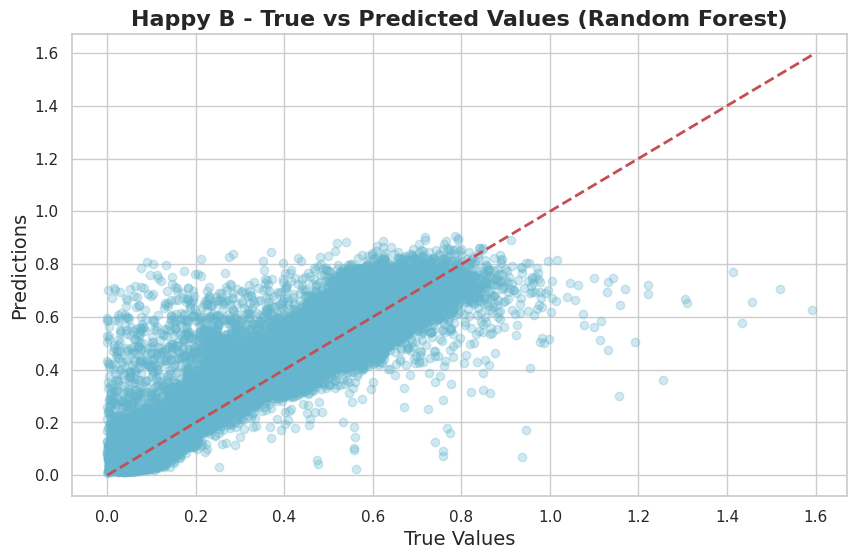

Happy C - Random Forest - RMSE: 0.13839115929948434, MAE: 0.0986401678725083, R²: 0.4276045568944393


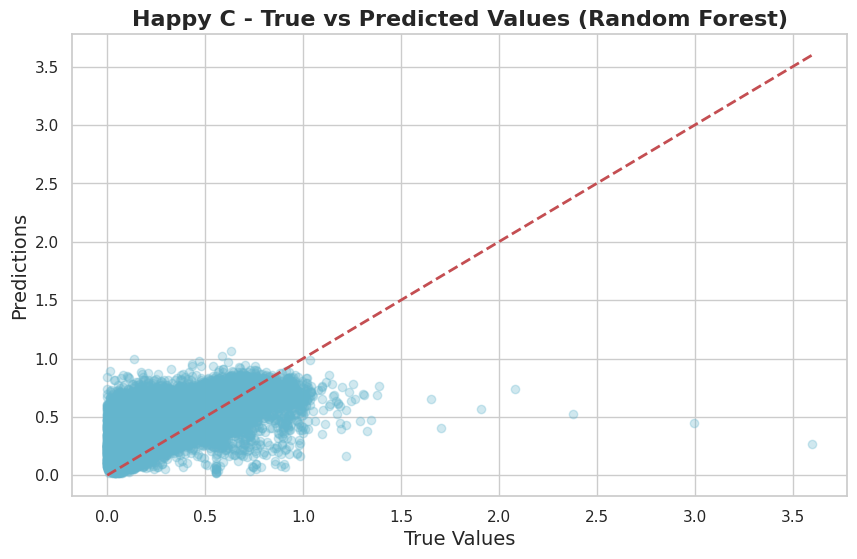

Happy D - Random Forest - RMSE: 0.19693658421194515, MAE: 0.1430762176476848, R²: 0.20388019037906135


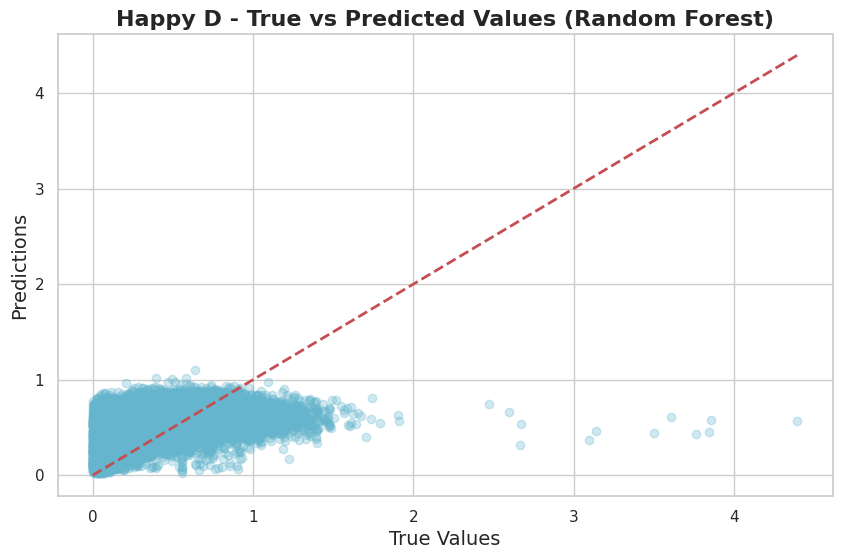

Happy B - Gradient Boosting - RMSE: 0.06568107085004436, MAE: 0.04139868990672532, R²: 0.9034030943693998


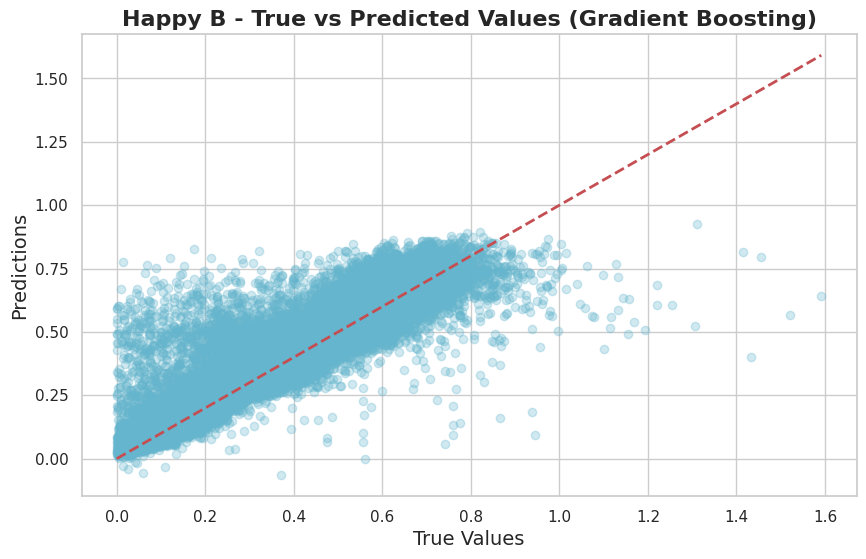

Happy C - Gradient Boosting - RMSE: 0.13500828134255116, MAE: 0.09768154751470268, R²: 0.4552461725916249


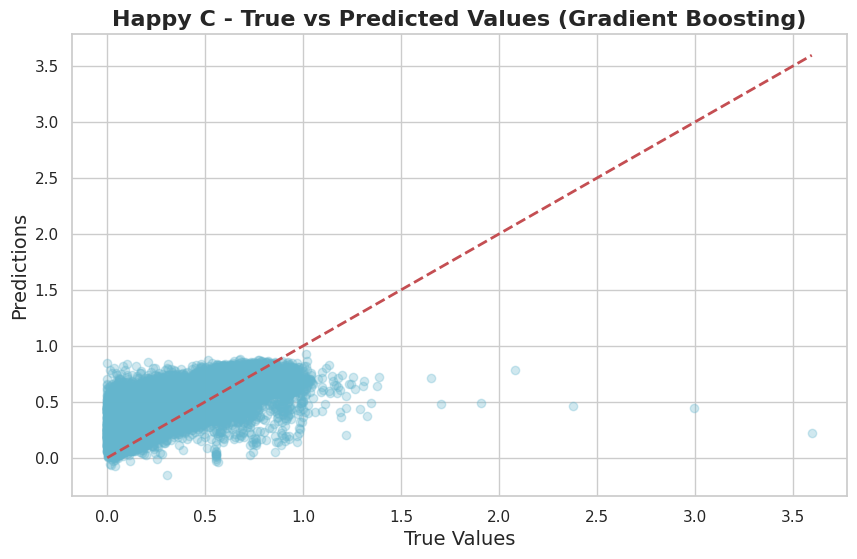

Happy D - Gradient Boosting - RMSE: 0.19380694411360122, MAE: 0.1411248554366758, R²: 0.22898239236364204


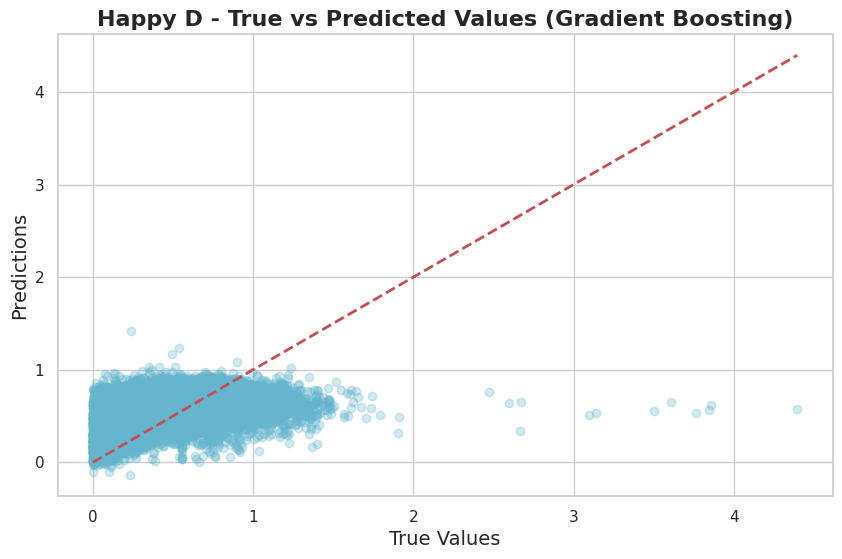

Happy B - Neural Network - RMSE: 0.0649238966653454, MAE: 0.04176561389168439, R²: 0.9056174035414901


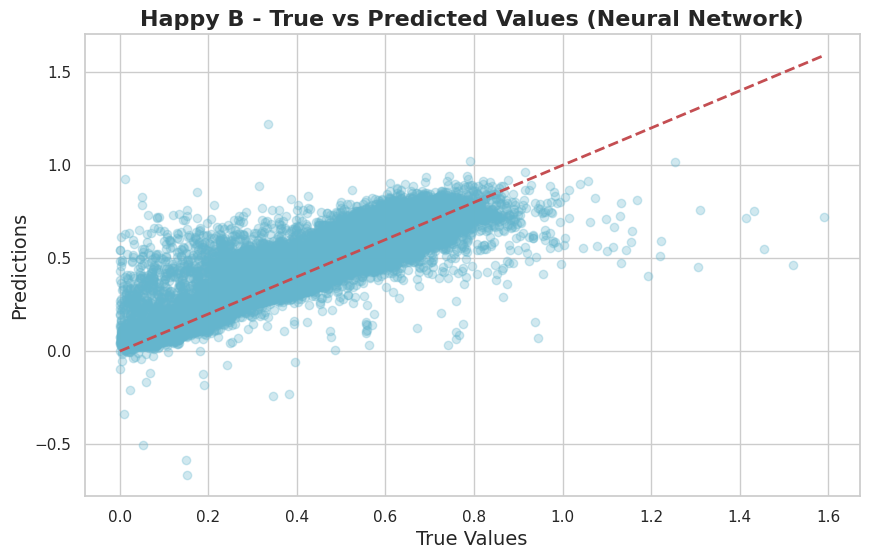

Happy C - Neural Network - RMSE: 0.12785244591867054, MAE: 0.09176925412809069, R²: 0.51146289503074


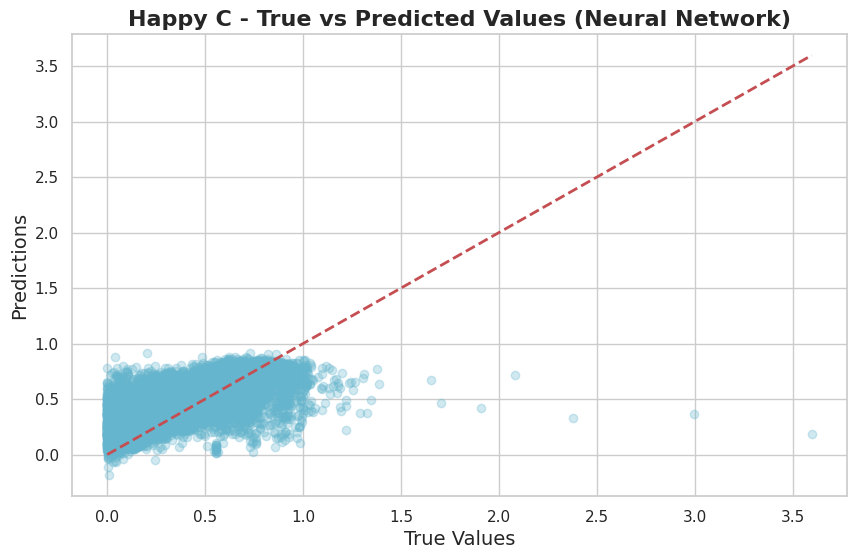

Happy D - Neural Network - RMSE: 0.18107030587796075, MAE: 0.13047598326409723, R²: 0.3269921978838608


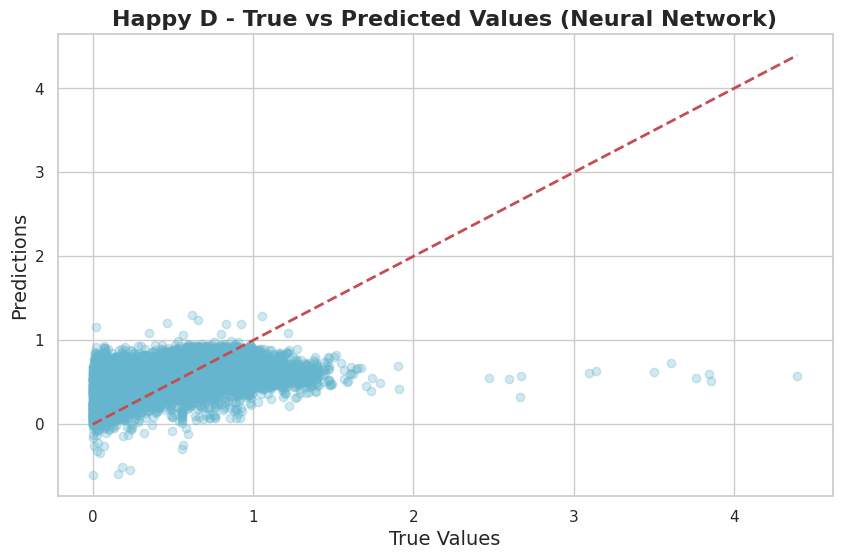

Happy B - Decision Tree - RMSE: 0.11875505731825155, MAE: 0.07401816994659545, R²: 0.6842182754952741


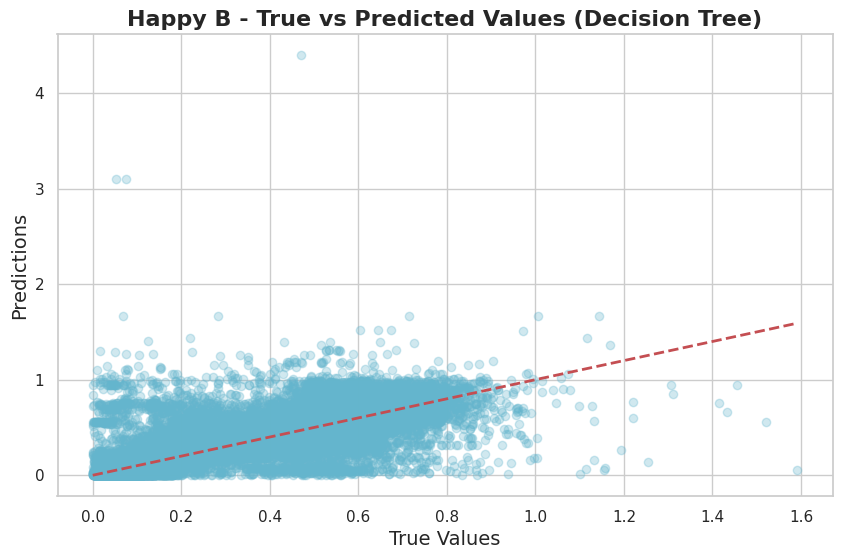

Happy C - Decision Tree - RMSE: 0.21628278944114007, MAE: 0.14726694694520434, R²: -0.3980522315263808


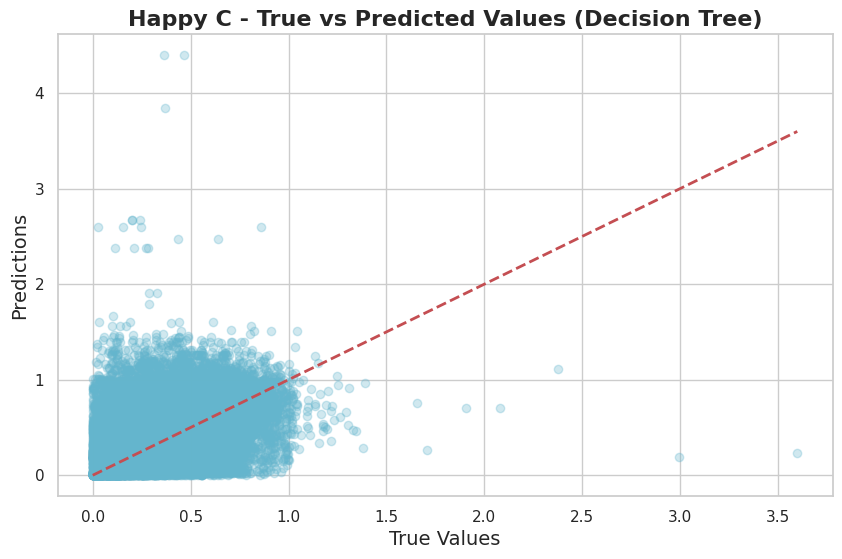

Happy D - Decision Tree - RMSE: 0.32604906444638737, MAE: 0.22972608678759948, R²: -1.1821848951517264


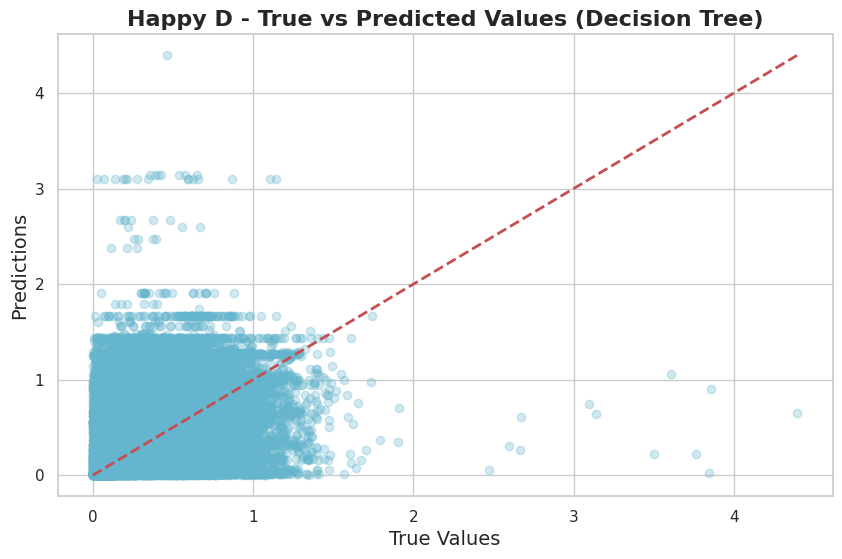

Happy B - XGBoost - RMSE: 0.06689704698268695, MAE: 0.04150942087706054, R²: 0.8997933232604542


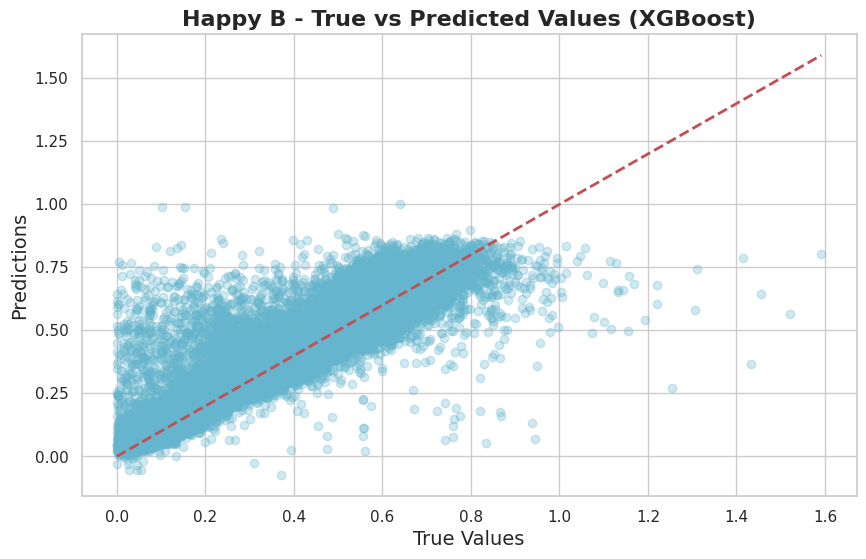

Happy C - XGBoost - RMSE: 0.13458048624008392, MAE: 0.09608889834408745, R²: 0.45869298045052875


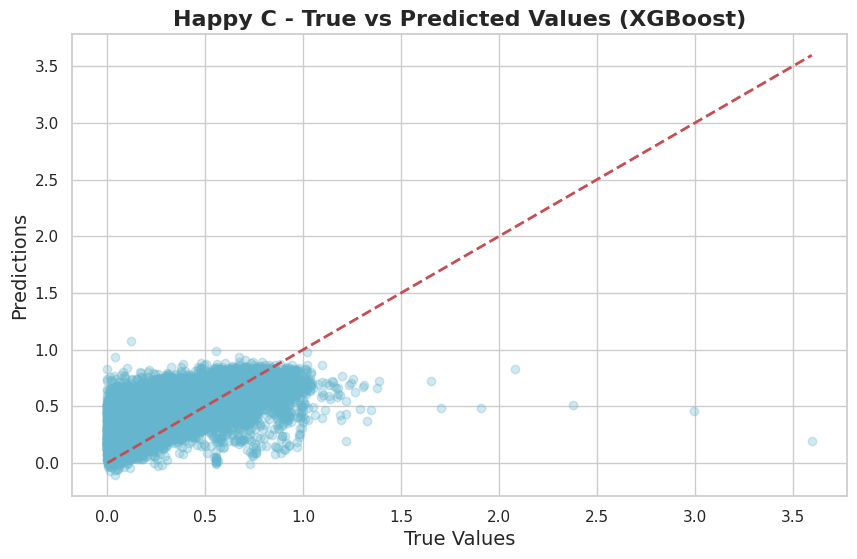

Happy D - XGBoost - RMSE: 0.19183061351626912, MAE: 0.13887978123380668, R²: 0.24462699535230092


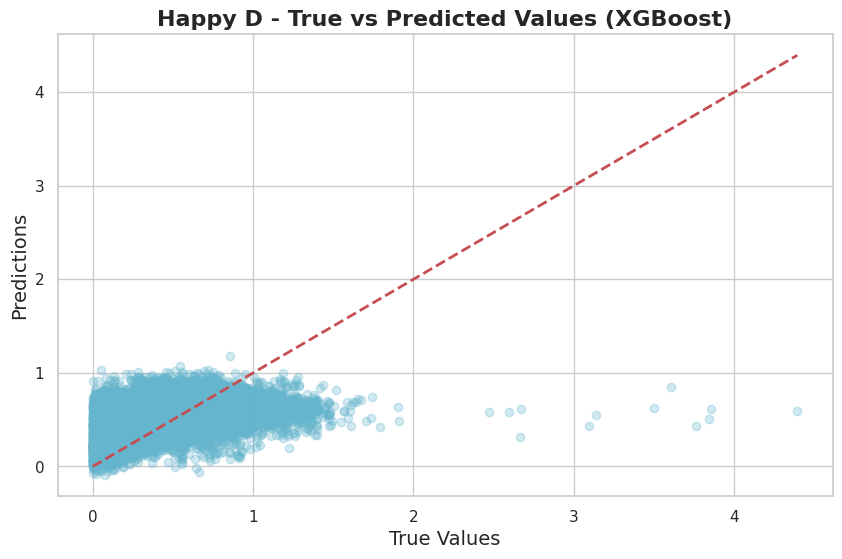

In [8]:
# Display message indicating the start of evaluation for the Happy dataset
print("Happy Dataset:")

# Prepare test datasets for the Happy dataset
# Mapping test datasets with their respective features and target variables
X_tests_happy = {
    'B': (happy_B[features], happy_B[target]),  # Test set B
    'C': (happy_C[features], happy_C[target]),  # Test set C
    'D': (happy_D[features], happy_D[target])   # Test set D
}

# Train and evaluate models using the Happy dataset
# The function `train_evaluate_model_with_datasets` will handle the training, evaluation, and visualization of models
train_evaluate_model_with_datasets(models, X_train_happy, y_train_happy, X_tests_happy, "Happy")


Teddy Dataset:
Teddy B - Random Forest - RMSE: 0.050276639244622896, MAE: 0.04014406039247077, R²: 0.6720215318061129


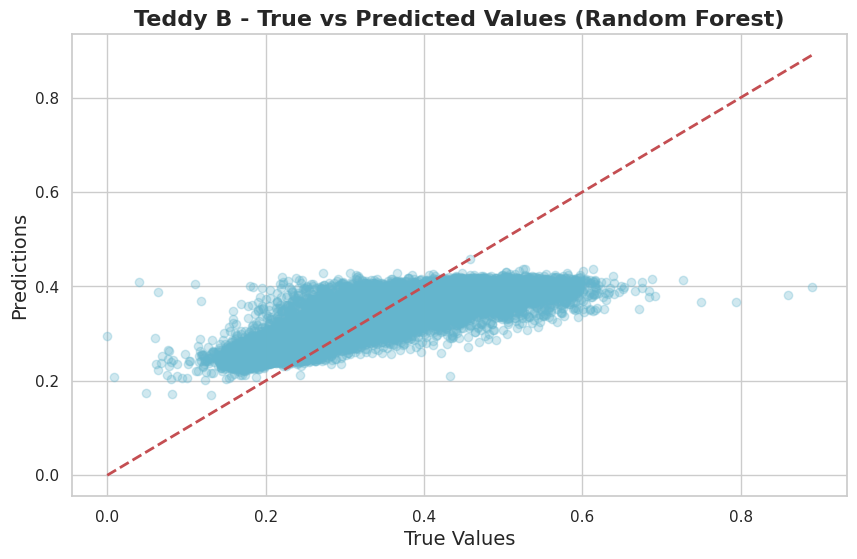

Teddy C - Random Forest - RMSE: 0.0561136315242349, MAE: 0.04538668082372754, R²: 0.6823312833147747


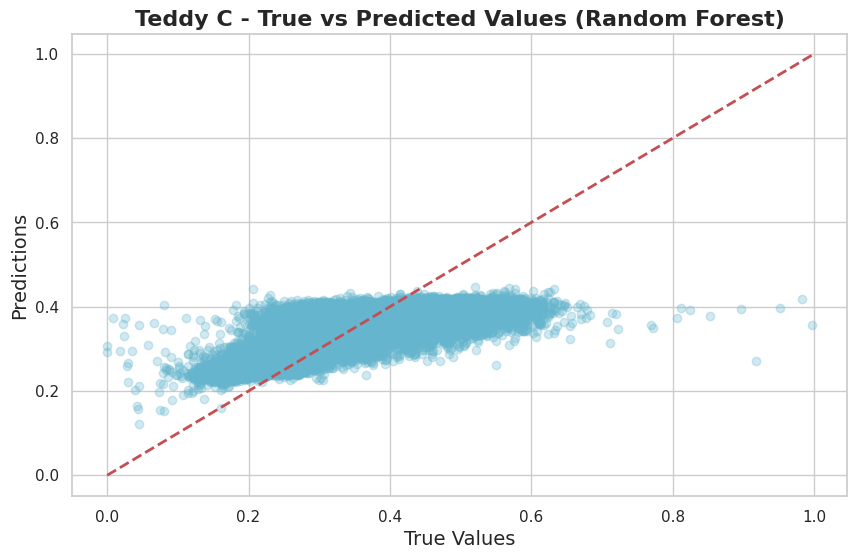

Teddy D - Random Forest - RMSE: 0.10486065814824881, MAE: 0.08763608720289287, R²: 0.7674643885514463


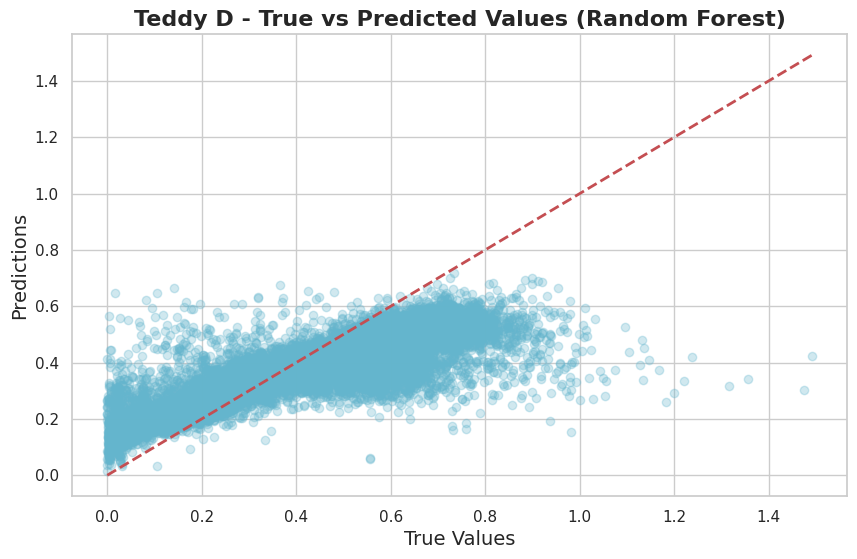

Teddy B - Gradient Boosting - RMSE: 0.05120430003536219, MAE: 0.0408319465252554, R²: 0.6598067269433884


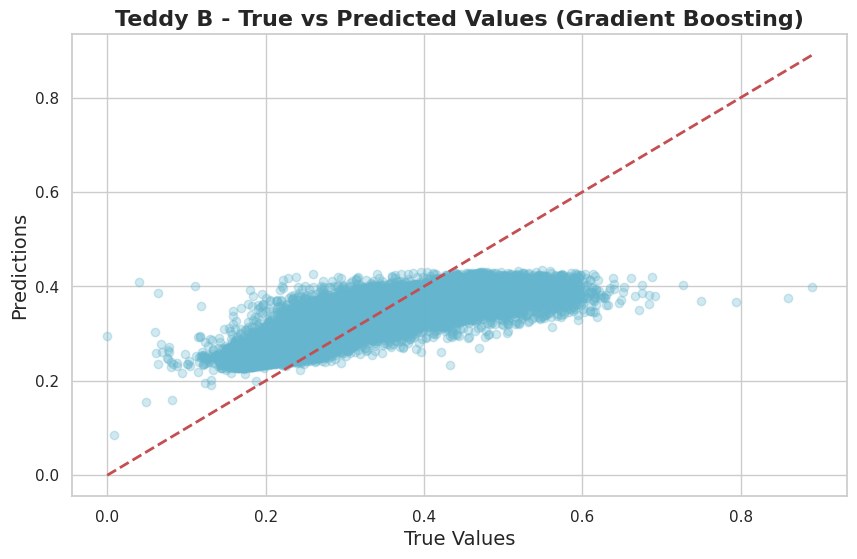

Teddy C - Gradient Boosting - RMSE: 0.05712890536187382, MAE: 0.04611402039629494, R²: 0.6707320180185251


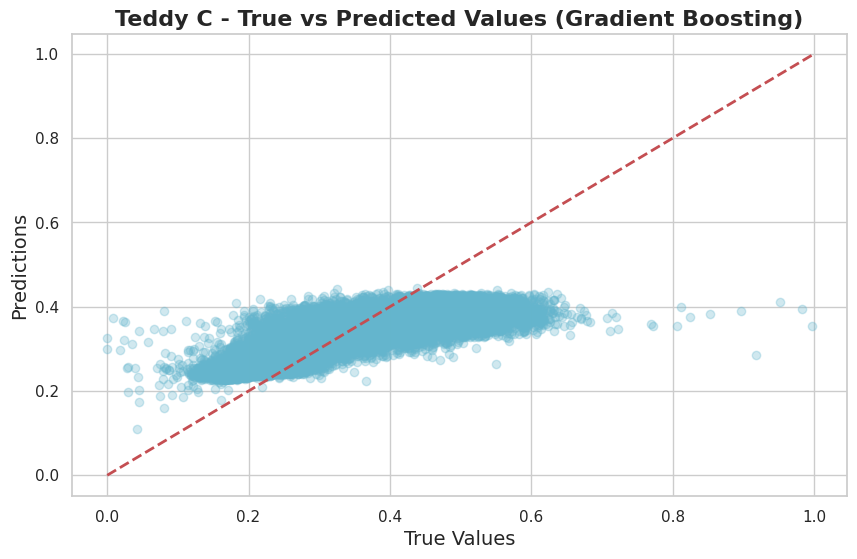

Teddy D - Gradient Boosting - RMSE: 0.10431156497442957, MAE: 0.08707729513586838, R²: 0.7698933150364822


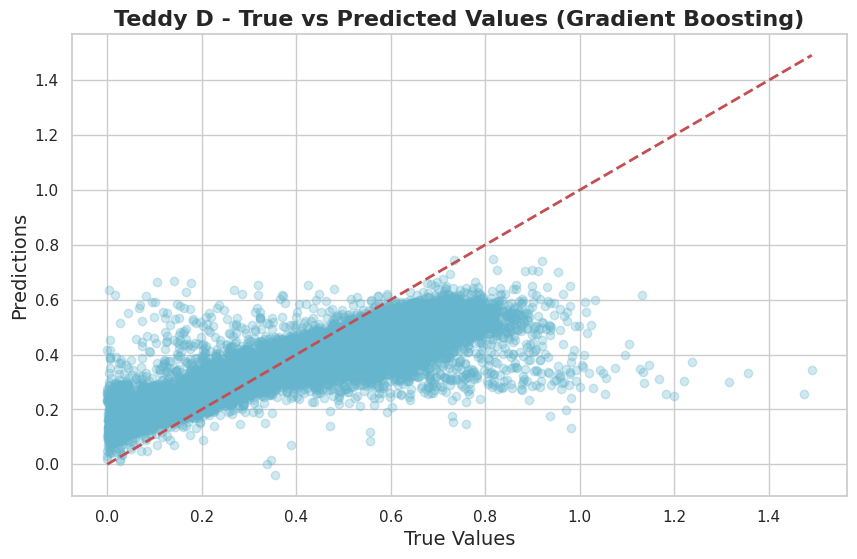

Teddy B - Neural Network - RMSE: 0.05201168627122148, MAE: 0.041272573989271394, R²: 0.6489938524376393


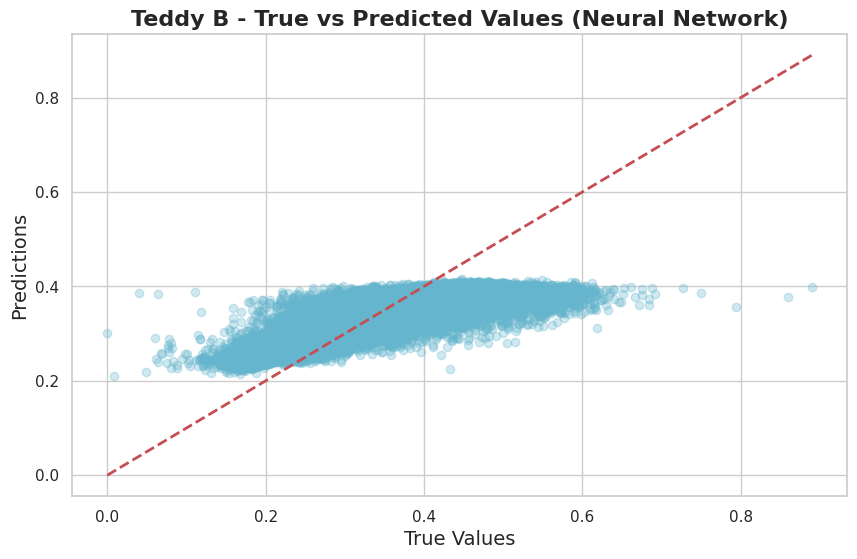

Teddy C - Neural Network - RMSE: 0.05818450207980645, MAE: 0.046764877274886235, R²: 0.6584515326136273


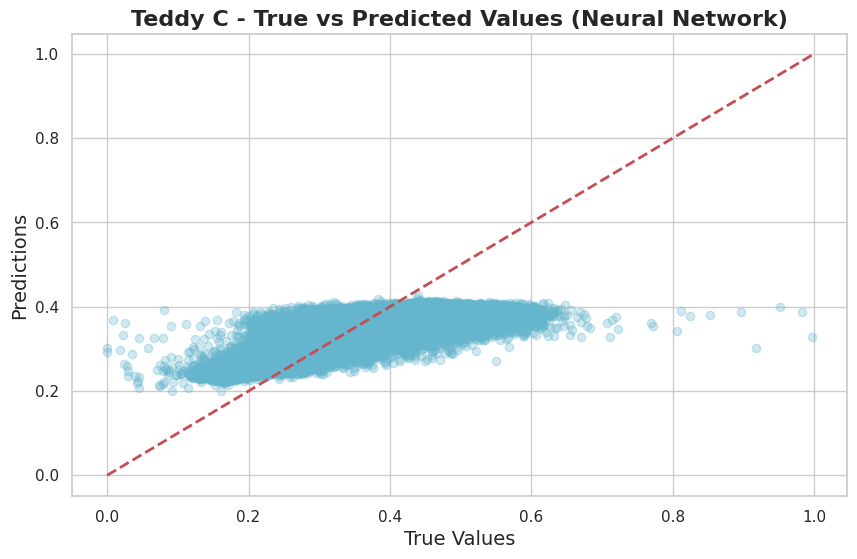

Teddy D - Neural Network - RMSE: 0.10692960285166983, MAE: 0.09000488169492271, R²: 0.7581978148857845


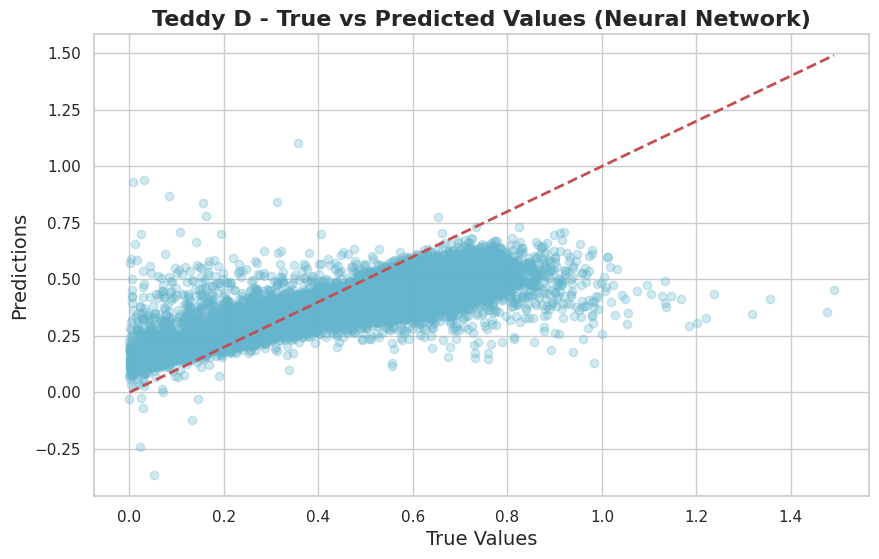

Teddy B - Decision Tree - RMSE: 0.05635772085513317, MAE: 0.04364147776868705, R²: 0.587883789694112


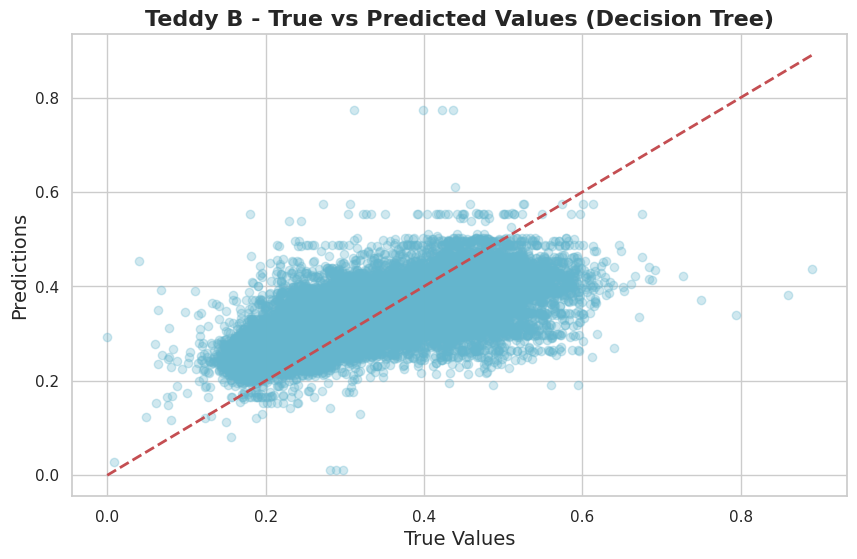

Teddy C - Decision Tree - RMSE: 0.062215388151656885, MAE: 0.04856333848744642, R²: 0.6094889507051233


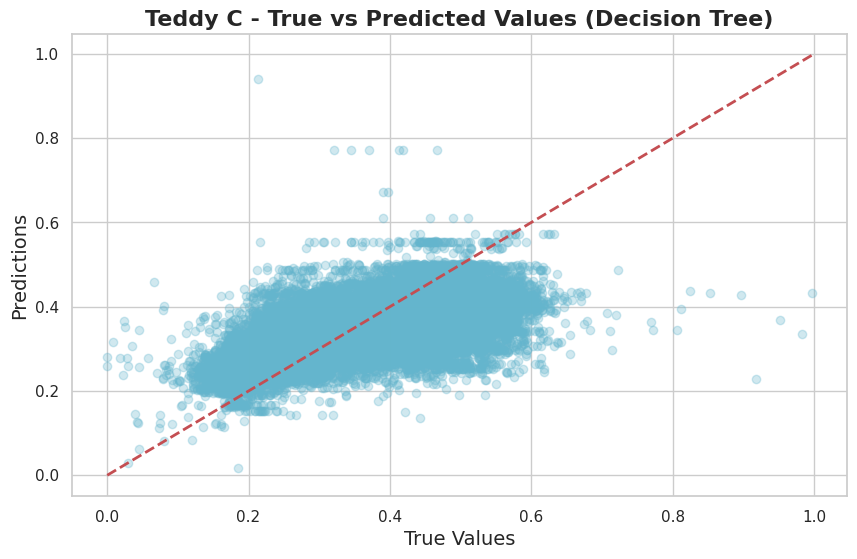

Teddy D - Decision Tree - RMSE: 0.11588308588283719, MAE: 0.09287040427269373, R²: 0.7160091047292167


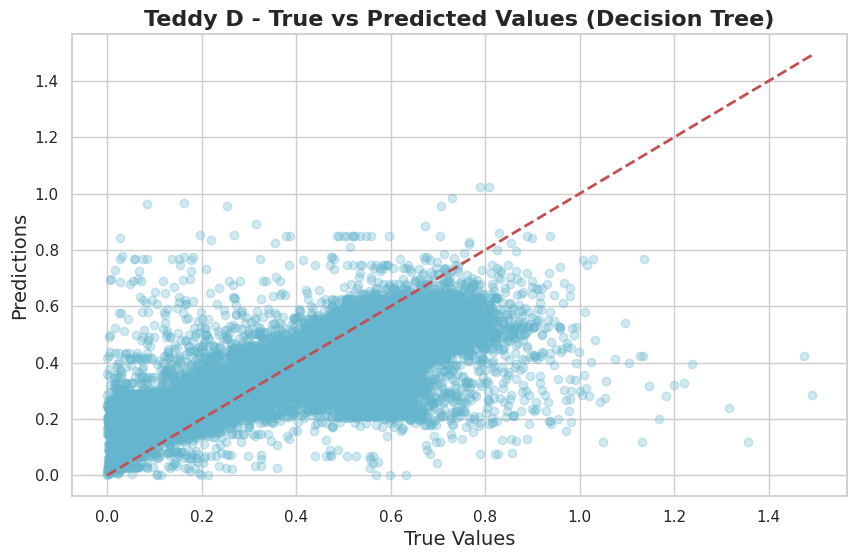

Teddy B - XGBoost - RMSE: 0.05083683989726308, MAE: 0.0406824803511537, R²: 0.6646719010849643


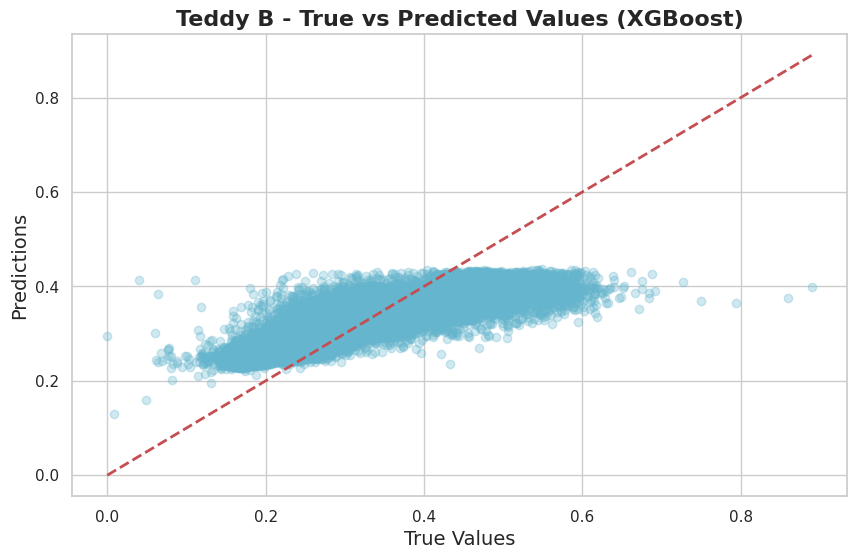

Teddy C - XGBoost - RMSE: 0.056598969330850186, MAE: 0.04588053970468379, R²: 0.6768123608720761


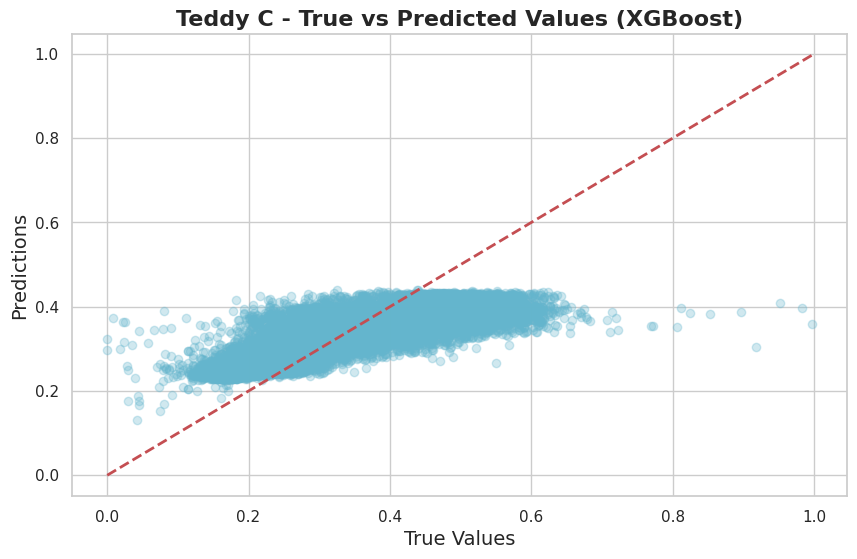

Teddy D - XGBoost - RMSE: 0.10362837482668717, MAE: 0.0864135925331677, R²: 0.7728976186644794


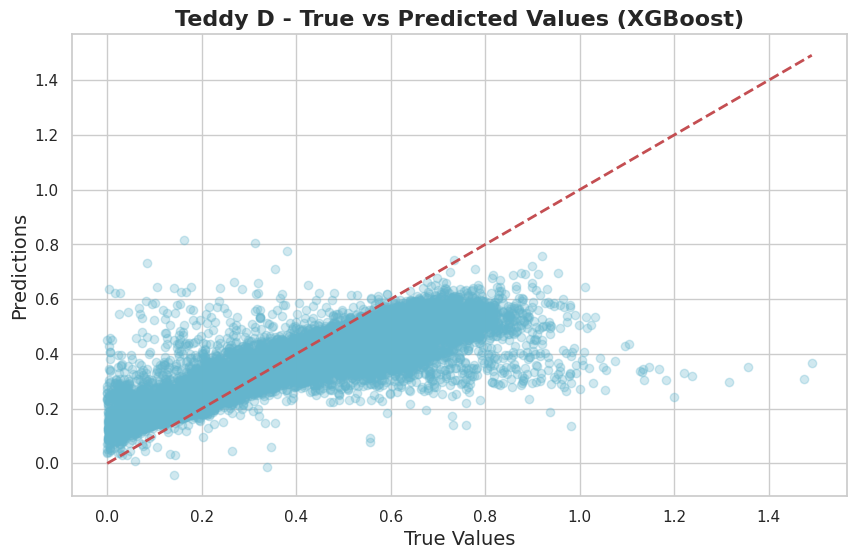

Model training, evaluation, and saving are complete.


In [10]:
# Display message indicating the start of evaluation for the Teddy dataset
print("Teddy Dataset:")

# Prepare test datasets for the Teddy dataset
# Mapping test datasets with their respective features and target variables
X_tests_teddy = {
    'B': (teddy_B[features], teddy_B[target]),  # Test set B
    'C': (teddy_C[features], teddy_C[target]),  # Test set C
    'D': (teddy_D[features], teddy_D[target])   # Test set D
}

# Train and evaluate models using the Teddy dataset
# The function `train_evaluate_model_with_datasets` will handle the training, evaluation, and visualization of models
train_evaluate_model_with_datasets(models, X_train_teddy, y_train_teddy, X_tests_teddy, "Teddy")

# Display completion message indicating that the model training, evaluation, and saving are complete
print("Model training, evaluation, and saving are complete.")

#Simple Linear Regression and Residual Analysis
Implements a simple linear regression model from scratch and performs
residual analysis using QQ plots and residual plots. These plots assess
the quality of the model's predictions on the "happy" and "teddy" datasets.

**Quantile-Quantile (QQ) Plot:**

The QQ plot assesses the normality of the residuals by comparing the distribution of residuals to a normal distribution. This helps determine if the residuals are normally distributed, which is an assumption in many regression models.

**Residual Plot:**

The residual plot visualizes the residuals (errors) against the predicted values. This plot helps identify patterns in the residuals, such as any systematic deviations from zero, which can indicate model inadequacies or issues like heteroscedasticity.
These plots are generated for both the "Happy" and "Teddy" datasets to ensure a thorough evaluation of model performance and residual behavior.








In [12]:

sns.set(style='whitegrid')

class SimpleLinearRegression:
    """
    A simple linear regression model implemented from scratch.

    Attributes:
    ----------
    weights : numpy.ndarray
        The weights (coefficients) of the linear regression model.
    """

    def __init__(self):
        self.weights = None

    def fit(self, X, y):
        """
        Fit the linear regression model to the training data.

        Parameters:
        ----------
        X : numpy.ndarray
            The input features (independent variables).
        y : numpy.ndarray
            The target values (dependent variable).
        """
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Add bias term (intercept)
        self.weights = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)  # Compute weights

    def predict(self, X):
        """
        Predict target values using the fitted linear regression model.

        Parameters:
        ----------
        X : numpy.ndarray
            The input features (independent variables).

        Returns:
        -------
        numpy.ndarray
            The predicted target values.
        """
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Add bias term (intercept)
        return X_b.dot(self.weights)

def qq_plot(y_true, y_pred, title):
    """
    Generate a Quantile-Quantile (QQ) plot to assess the normality of residuals.

    Parameters:
    ----------
    y_true : numpy.ndarray
        The true target values.
    y_pred : numpy.ndarray
        The predicted target values.
    title : str
        The title of the plot.
    """
    residuals = y_true - y_pred
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(title)
    plt.show()

def residual_plot(y_true, y_pred, title):
    """
    Generate a residual plot to evaluate the relationship between predicted values and residuals.

    Parameters:
    ----------
    y_true : numpy.ndarray
        The true target values.
    y_pred : numpy.ndarray
        The predicted target values.
    title : str
        The title of the plot.
    """
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.show()


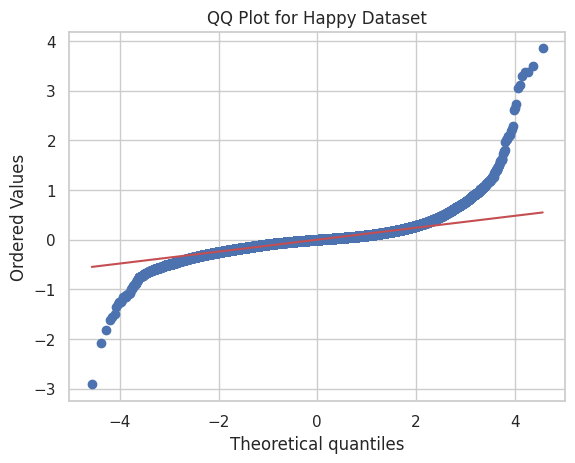

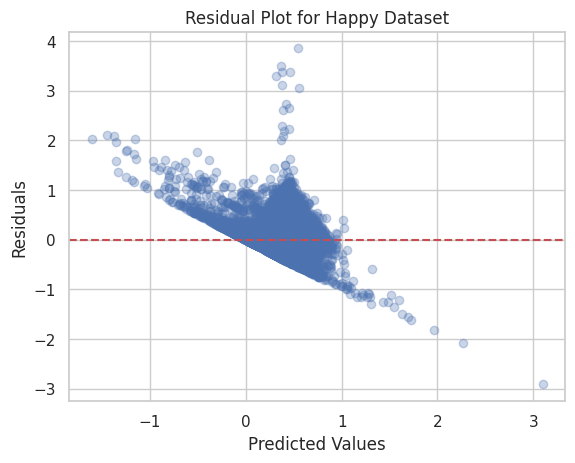

In [13]:
# Train and Evaluate Simple Linear Regression on Happy Dataset

model = SimpleLinearRegression()
model.fit(X_happy, y_happy)  # Train the model on the happy dataset
y_happy_pred = model.predict(X_happy)  # Predict values

qq_plot(y_happy, y_happy_pred, "QQ Plot for Happy Dataset")  # QQ plot
residual_plot(y_happy, y_happy_pred, "Residual Plot for Happy Dataset")  # Residual plot


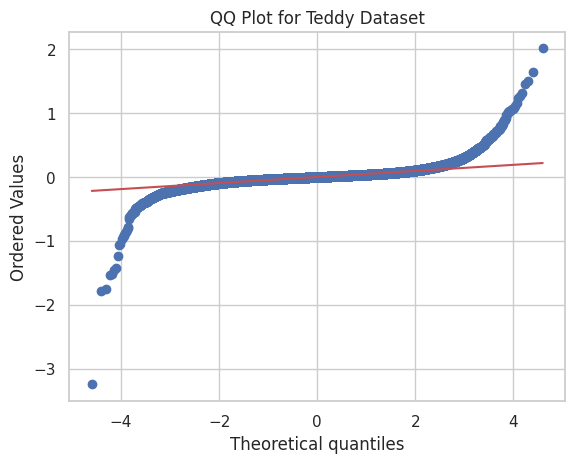

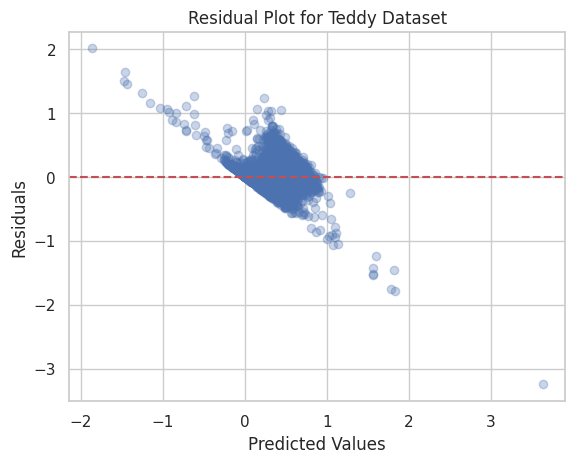

In [14]:
# Train and Evaluate Simple Linear Regression on Teddy Dataset

model.fit(X_teddy, y_teddy)  # Train the model on the teddy dataset
y_teddy_pred = model.predict(X_teddy)  # Predict values

qq_plot(y_teddy, y_teddy_pred, "QQ Plot for Teddy Dataset")  # QQ plot
residual_plot(y_teddy, y_teddy_pred, "Residual Plot for Teddy Dataset")  # Residual plot